# Training script

### Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from transformers import AutoTokenizer, BertModel
from datasets import load_dataset
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import string
import fasttext
from sklearn.svm import SVC
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.metrics import accuracy_score, classification_report
import pickle

import os
os.makedirs('saved_models', exist_ok=True)

model = BertModel.from_pretrained("bert-base-uncased")
embedding_matrix = model.embeddings.word_embeddings.weight
transformer_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Models

In [2]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, num_cells, hidden_size, bi, out_features):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, num_layers = num_cells, hidden_size = hidden_size, bidirectional=bi, batch_first = True)
        self.batch_norm = nn.BatchNorm1d(num_features = hidden_size * 2 if bi else hidden_size)
        self.dropout = nn.Dropout(p = 0.2)
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(in_features = hidden_size * 2 if bi else hidden_size, out_features = out_features)
        #self.relu2 = nn.ReLU()
        #self.linear2 = nn.Linear(in_features = 100, out_features = out_features)
        
        # with torch.no_grad():
            # self.linear1.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
            # self.linear2.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
    
    def forward(self, embedding_sequence):
        # Pad first sequence to max length
        # embedding_sequence[0] = torch.concat([embedding_sequence[0], torch.zeros((self.max_sequence_length - embedding_sequence[0].shape[0] ,self.input_size)).cuda()])
        # Get lenghts vector for every embeddings sequence to later use for packing
        lengths = torch.Tensor([embedding.shape[0] for embedding in embedding_sequence]).long()
        # Pad sequence
        padded_sequence = pad_sequence(embedding_sequence)
        # Pack sequence
        packed_sequence = pack_padded_sequence(padded_sequence, lengths = lengths, enforce_sorted = False)
        # print(padded_sequence.shape)
        
        packed_out, _ = self.lstm(packed_sequence)
        padded_out, _ = pad_packed_sequence(packed_out)
    
        # print(padded_out.shape)
    
        out_forward = padded_out[lengths - 1, range(padded_out.shape[1]), :self.hidden_size]
        out_reverse = padded_out[0, :, self.hidden_size:]
        
        # print(out_forward.shape)
        # print(out_reverse.shape)
        
        out = torch.cat([out_forward, out_reverse], dim = 1)
        
        # print(out.shape)
        
        x = self.batch_norm(out)
        x = self.dropout(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.linear1(x)
        #x = self.relu2(x)
        #x = self.linear2(x)
        return x

In [3]:
# model = MLP(37).cuda() # Replace model instantiation with another class here (SVC for example) if wishing to test other models
# model = XGBClassifier(n_estimators = 300, max_depth = 13, learning_rate = 0.01)
# model = XGBClassifier(n_estimators = 100, max_depth = 39 * 2, learning_rate = 0.01)
# model = SVC(C = 1, kernel = 'rbf', gamma = 'scale')
# TODO: somehting is wrong since the dict-based model achieves 0.30 accuracy
# and it only encounters 30/3000 not previously seen examples in the test set
# so it should have a 0.99 accuracy


nr_features = 768
batch_size = 32
learning_rate = 2e-5
epochs = 10
patience = 2
class_weight_beta = 0.999
use_class_weights = False

In [4]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('Booking'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service == 'restaurant':
            services.add('restaurant')
        elif service == 'hotel':
            services.add('hotel')
        else:
            services.add('other')
        if len(services) == 3:
            break
    return list(services)

### Loading the dataset

In [5]:

def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_to_be_retrieved_info(dataset, limit_nothing = False, limit_nothing_count = 200):
    user_act_types_list = []
    user_slots_per_act_type_list = []
    to_be_retrieved_list = []
    embeddings_list = []
    to_be_requested_list = []
    
    nothing_count = 0
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        for j, (utterance, speaker, dialogue_act, frames) in enumerate(zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'], turns['frames'])):
            # if speaker != 1:
                # continue
            # Skip using dialogue act intents
            # print(dialogue_act['dialog_act']['act_type'])
            # if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                # continue
            # Skip using frame services
            # if 'other' in process_service_list(frames['service']):
                # continue
            services = frames['service']
            if speaker == 0:
                user_utterance = utterance
                current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]
                
            act_types = dialogue_act['dialog_act']['act_type']
            act_slots = dialogue_act['dialog_act']['act_slots']
            
            # if speaker == 1 and not any(act_type.startswith("Hotel") or act_type.startswith("Restaurant") or act_type.startswith("Booking") for act_type in act_types):
            #     user_act_types_list.pop()
            #     user_slots_per_act_type_list.pop()
            #     continue
            
            # print(act_types)
            # if speaker == 0:
            #     if len([1 for act_type in dialogue_act['dialog_act']['act_type'] if act_type.startswith('general')]) == len(dialogue_act['dialog_act']['act_type']):
            #         skip_bot = True
            #         continue
                    
            #     if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
            #         skip_bot = True
            #         continue
            #     if 'other' in process_intent_list(turns['dialogue_acts'][j + 1]['dialog_act']['act_type']):
            #         skip_bot = True
            #         continue
            #     skip_bot = False
            # else:
            #     if skip_bot:
            #         continue
            if speaker == 0:
                skip_bot = False
                if not any(da.startswith("Hotel") or da.startswith("Restaurant") or da.startswith("Booking") for da in act_types):
                    skip_bot = True
                    continue
            elif skip_bot:
                    continue
            
            # print(act_slots)
            # print(act_types)
            slots_per_act_type = []
            to_be_retrieved = set()
            to_be_requested = set()
            for act_type, slots in zip(act_types, act_slots):
                slot_names = slots['slot_name']
                slot_values = slots['slot_value']
                
                domain = act_type.split('-')[0].lower()
                if domain == 'booking' and len(current_booking_service)==1:
                    domain = current_booking_service[0]
                
                # to_be_retrieved.add(domain + '-availability')
                
                # if 'hotel' in domain or 'restaurant' in domain:
                if speaker == 0: # When it's the user's turn
                    for slot_name, slot_value in zip(slot_names, slot_values):
                        if slot_name != 'none':
                            slots_per_act_type.append(act_type.lower() + '-' + slot_name + ':' + slot_value)
                elif domain in ["hotel", "restaurant", "booking", "general"]: # When it's the bot's turn
                    act_type_relevant_slots = [(slot_name, slot_value) for slot_name, slot_value in zip(slot_names, slot_values) if slot_value != '?' and slot_name != 'none']
                    to_be_retrieved.update(set([domain + '-' + slot_name + ':' + slot_value for slot_name, slot_value in act_type_relevant_slots]))
                    
                    if len(to_be_retrieved) != 0 and any((slot_name_value.split(":")[0]!=domain+"-none" for slot_name_value in to_be_retrieved)) and not "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability:yes')
                    elif "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability:no')
                    
                    
                    to_be_requested_relevant_slots = [(slot_name, slot_value) for slot_name, slot_value in zip(slot_names, slot_values) if slot_value == '?' and slot_name != 'none']
                    to_be_requested.update(set([domain + '-' + slot_name for slot_name, _ in to_be_requested_relevant_slots]))
                
            if speaker == 0: # When it's the user's turn
                user_act_types_list.append(act_types)
                user_slots_per_act_type_list.append(slots_per_act_type)
                
                # nr += 1
                # print(nr)
                # print("Input:", slots_per_act_type)
            else: # When it's the bot's turn
                # if limit_nothing and len(to_be_requested) == 0:
                #     if nothing_count == limit_nothing_count:
                #         continue
                #     nothing_count += 1
                
                if len(to_be_requested) == 0:
                    to_be_requested.add('NOTHING')
                
                to_be_retrieved_list.append(list(to_be_retrieved))
                to_be_requested_list.append(list(to_be_requested))
                
                # print(act_types)
                
                user_slots_per_act_type = user_slots_per_act_type_list[-1]
                to_be_retrieved = to_be_retrieved_list[-1]
                
                # !!! Surprisingly, adding the annotations actually improves performance 
                input_text = user_utterance + ' | USER SLOTS PER ACT ' + ', '.join(user_slots_per_act_type) + ' | RETRIEVED SLOTS ' + ', '.join(to_be_retrieved)
                print("INPUT TEXT:", input_text)
                
                print("TO BE REQ:", to_be_requested)
                
                tokenized_seen_slots = transformer_tokenizer(input_text)
                with torch.no_grad():
                    embedding = embedding_matrix[tokenized_seen_slots.input_ids].detach().numpy()
                embeddings_list.append(embedding)
            
    return embeddings_list, to_be_requested_list

In [6]:
dataset = load_dataset('multi_woz_v22')

try:
    train
    print("Dataset already loaded, moving on")
except:
    train = preprocess_split(dataset, 'train')
    test = preprocess_split(dataset, 'test')
    val = preprocess_split(dataset, 'validation')
    train_embeddings_list, train_to_be_requested_list = extract_to_be_retrieved_info(train)
    test_embeddings_list, test_to_be_requested_list = extract_to_be_retrieved_info(test)
    print(len(test_embeddings_list))
    val_embeddings_list, val_to_be_requested_list = extract_to_be_retrieved_info(val)

No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (/home/adrian/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

  1%|          | 38/6321 [00:00<00:16, 370.51it/s]

INPUT TEXT: i need a place to dine in the center thats expensive | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-choice:several, restaurant-food:African, restaurant-food:Asian, restaurant-food:British, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation? | USER SLOTS PER ACT restaurant-request-food:? | RETRIEVED SLOTS restaurant-name:Bedouin, restaurant-food:Afrian, restaurant-availability:yes, restaurant-area:centre
TO BE REQ: {'NOTHING'}
INPUT TEXT: Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel? | USER SLOTS PER ACT hotel-inform-pricerange:expensive, hotel-inform-type:hotel, restaurant-request-phone:? | RETRIEVED SLOTS restaurant-name:Bedouin, restaurant-phone:01223367660, restaurant-availability:yes, hotel-area:center of town, hotel-name:t

  2%|▏         | 120/6321 [00:00<00:16, 377.10it/s]

{'hotel-area'}
INPUT TEXT: Yes, I'll be staying on the South side so a cheap 4 star guesthouse with free wifi will do | USER SLOTS PER ACT hotel-inform-area:south, hotel-inform-internet:yes, hotel-inform-stars:4, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-availability:yes, hotel-name:Rosa's Bed and Breakfast
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can i just get the address please? | USER SLOTS PER ACT hotel-request-address:? | RETRIEVED SLOTS general-availability:yes, hotel-availability:yes, hotel-address:53 Roseford Road
TO BE REQ: {'NOTHING'}
INPUT TEXT: No, that's all I need. | USER SLOTS PER ACT hotel-request-name:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for a cheap restaurant that serves Scandinavian food | USER SLOTS PER ACT restaurant-inform-food:scandinavian, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Are there any cheap restaurants that serve Italian food? | USER SLOTS PER ACT restaurant-inform-foo

  3%|▎         | 196/6321 [00:00<00:19, 311.18it/s]

INPUT TEXT: Asian oriental food sounds good. What options do you have available? | USER SLOTS PER ACT restaurant-inform-food:asian oriental | RETRIEVED SLOTS restaurant-availability:yes, restaurant-choice:a few
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: I'm not really worried about price. Which do you suggest that is located in the centre? | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-pricerange:dontcare | RETRIEVED SLOTS restaurant-name:Th Kymmoy, restaurant-pricerange:expensive, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I think I would like to be in the moderate price range please. | USER SLOTS PER ACT restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-pricerange:moderate, restaurant-name:yippee noddle bar, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Actually, can you give me the phone number for Yippee Noodle Bar instead? | USER SLOTS PER ACT restaurant-inform-name:yippee noodle bar, restaurant-req

  4%|▍         | 262/6321 [00:00<00:19, 314.75it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: I do want it to be a 4-star place. | USER SLOTS PER ACT hotel-inform-stars:4 | RETRIEVED SLOTS hotel-stars:4, hotel-type:hotels, hotel-availability:yes, hotel-area:north
TO BE REQ: {'hotel-area'}
INPUT TEXT: No, I like the North. Perhaps there is a guesthouse that is 4 stars? | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-stars:4, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-pricerange:cheap, hotel-choice:several, hotel-pricerange:moderate, hotel-stars:4, hotel-type:guesthouses, hotel-availability:yes, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would prefer the cheap price range. | USER SLOTS PER ACT hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-name:worth house, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: What is the price of the Worth House? | USER SLOTS PER ACT hotel-inform-name:worth house | RETRIEVED SLOTS hotel-phone:01223316074, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: can y

  5%|▌         | 337/6321 [00:00<00:17, 343.19it/s]

The area doesn't matter, but I would like it to be an expensive 4 star hotel. | USER SLOTS PER ACT hotel-inform-area:dontcare, hotel-inform-pricerange:expensive, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-choice:2, hotel-name:the Huntingdon Marriott Hotel, hotel-choice:first, hotel-area:centre, hotel-area:west, hotel-name:the University Arms Hotel, hotel-availability:yes, hotel-choice:other
TO BE REQ: {'NOTHING'}
INPUT TEXT: The Huntingdon Marriott Hotel sounds really nice. Could you book us a room there for 2 nights on Tuesday? | USER SLOTS PER ACT hotel-inform-bookday:tuesday, hotel-inform-bookstay:2, hotel-inform-name:huntingdon marriott hotel | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookpeople'}
INPUT TEXT: Just one person please | USER SLOTS PER ACT hotel-inform-bookpeople:1 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: Try booking the room for just one night, please. | USER SLOTS PER ACT hotel-inform-bookstay:1 | RETRIEVED SLOTS hotel-bookstay:1, hotel-bookday:Tuesda

  6%|▌         | 372/6321 [00:01<00:17, 339.64it/s]

INPUT TEXT: Okay, that sounds good. I need to make a reservation for 2 people on Tuesday. | USER SLOTS PER ACT restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:2 | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-booktime'}
INPUT TEXT: How about 13:15? | USER SLOTS PER ACT restaurant-inform-booktime:13:15 | RETRIEVED SLOTS restaurant-ref:97AAF776, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hi, I am looking for a restaurant that is expensive and serves European food. | USER SLOTS PER ACT restaurant-inform-food:european, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-choice:5, restaurant-availability:yes
TO BE REQ: {'restaurant-area'}
INPUT TEXT: No specific area, but I would like it for Friday. | USER SLOTS PER ACT restaurant-request-name:? | RETRIEVED SLOTS restaurant-name:City Stop Restaurant, restaurant-availability:yes
TO BE REQ: {'restaurant-bookpeople', 'restaurant-booktime'}
INPUT TEXT: I'd like to make reservations for 7 people at 

  7%|▋         | 440/6321 [00:01<00:19, 300.61it/s]

TO BE REQ: {'restaurant-food'}
INPUT TEXT: Yes, I would prefer chinese please. | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-availability:yes, restaurant-name:tang chinese restaurant, restaurant-address:napier street city centre
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes. Make a reservation for 8 people on Monday at 11:30. | USER SLOTS PER ACT restaurant-inform-bookpeople:8, restaurant-inform-booktime:11:30 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Please book the restaurant as requested. I would also like the reference number. | USER SLOTS PER ACT restaurant-request-ref:? | RETRIEVED SLOTS general-availability:yes, restaurant-availability:yes, restaurant-ref:JCH9E5BI
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you help me find an expensive restaurant in the west? | USER SLOTS PER ACT restaurant-inform-area:west, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-choice:nine, restaurant-availability:yes
TO BE REQ: {'restaurant-food

  8%|▊         | 503/6321 [00:01<00:19, 293.63it/s]

INPUT TEXT: I'd prefer a hotel rather than a guesthouse. | USER SLOTS PER ACT hotel-inform-type:hotel | RETRIEVED SLOTS hotel-internet:yes, hotel-area:centre, hotel-parking:yes, hotel-name:Gonville hotel, hotel-name:The Lensfield hotel, hotel-area:south, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Could you give me more information the the Lensfield? | USER SLOTS PER ACT hotel-inform-name:lensfield | RETRIEVED SLOTS hotel-address:53-57 lensfield road, hotel-pricerange:expensive, hotel-name:The lensfield hotel, hotel-availability:yes, hotel-area:south, hotel-stars:3
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please, book it for Saturday for 3 people for 3 nights. | USER SLOTS PER ACT hotel-inform-bookday:saturday, hotel-inform-bookpeople:3, hotel-inform-bookstay:3 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: How about 2 nights? Would that work? | USER SLOTS PER ACT hotel-inform-bookstay:2 | RETRIEVED SLOTS hotel-bookstay:2, hotel-availability:yes, hotel-ref:716V6QS6
T

  9%|▉         | 566/6321 [00:01<00:19, 289.30it/s]

What area of town is that in? | USER SLOTS PER ACT restaurant-request-area:? | RETRIEVED SLOTS restaurant-availability:yes, restaurant-area:south
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need to find a 4 star rated place to stay with free parking. | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-area:in town, hotel-availability:yes, hotel-choice:19
TO BE REQ: {'hotel-area'}
INPUT TEXT: No particular area but I would like it to be a hotel type in the moderate price range. | USER SLOTS PER ACT hotel-inform-pricerange:moderate | RETRIEVED SLOTS hotel-availability:yes, hotel-name:acorn guest house
TO BE REQ: {'NOTHING'}
INPUT TEXT: I think I'll take a drive past first and make sure it doesn't look dodgy. Can you give me the address please? | USER SLOTS PER ACT hotel-request-address:? | RETRIEVED SLOTS general-availability:yes, hotel-address:154 chesterton road, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes. 7 people 5 nights from Wedne

  9%|▉         | 596/6321 [00:01<00:21, 269.73it/s]

INPUT TEXT: Okay should we try a different restaurant then...? I've never had this problem before... | USER SLOTS PER ACT  | RETRIEVED SLOTS restaurant-choice:two, restaurant-area:West, restaurant-availability:yes, restaurant-food:Italian
TO BE REQ: {'NOTHING'}
INPUT TEXT: That would work, I need to get a table the same day as my other booking. | USER SLOTS PER ACT  | RETRIEVED SLOTS restaurant-ref:3P75NAMG, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need a place to stay in Cambridge. It should be either a hotel or guesthouse with 1 star and moderate price range. Can you help me with that? | USER SLOTS PER ACT hotel-inform-stars:1 | RETRIEVED SLOTS hotel-stars:1, hotel-area:anywhere in Cambridge, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Okay, how about 2 stars? It does need to include free parking. | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-stars:2 | RETRIEVED SLOTS hotel-stars:2, hotel-name:ashley hotel, hotel-availability:yes
TO

 10%|█         | 655/6321 [00:02<00:20, 272.53it/s]

INPUT TEXT: i need a hotel with wifi in the north part of town | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-internet:yes | RETRIEVED SLOTS 
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: I am open as far as price range, but I would love a 4 star place. | USER SLOTS PER ACT hotel-inform-stars:4 | RETRIEVED SLOTS hotel-type:hotel, hotel-internet:yes, hotel-stars:4, hotel-availability:yes, hotel-area:north
TO BE REQ: {'hotel-stars'}
INPUT TEXT: No, the hotel needs to have a 4 star rating. Can you please check your system again? Thanks | USER SLOTS PER ACT hotel-inform-stars:4 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-stars'}
INPUT TEXT: Perhaps there is a guestroom? | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'hotel-area'}
INPUT TEXT: Just something in the north, 4 star and free wifi? | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-choice:8, hotel-availability:yes, hotel-type:guesthouse
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT

 11%|█▏        | 717/6321 [00:02<00:19, 289.45it/s]

{'NOTHING'}
INPUT TEXT: Yes. How about a restaurant serving british food? | USER SLOTS PER ACT restaurant-inform-food:british | RETRIEVED SLOTS restaurant-choice:several, restaurant-food:British, restaurant-pricerange:expensive, restaurant-availability:yes
TO BE REQ: {'restaurant-area'}
INPUT TEXT: No it doesn't matter | USER SLOTS PER ACT restaurant-inform-area:dontcare | RETRIEVED SLOTS restaurant-name:Fitzbillies, restaurant-food:British, restaurant-pricerange:expensive, restaurant-area:center of town, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: May I have the phone number, please? | USER SLOTS PER ACT restaurant-request-phone:? | RETRIEVED SLOTS restaurant-availability:yes, restaurant-phone:01223 352500, general-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can I have the address please? | USER SLOTS PER ACT restaurant-request-name:? | RETRIEVED SLOTS restaurant-availability:yes, restaurant-name:fitzbillies restaurant, restaurant-address:51 Trumpington Stre

 12%|█▏        | 781/6321 [00:02<00:18, 297.78it/s]

{'NOTHING'}
INPUT TEXT: Three people starting on saturday for four nights please. I also need a reference number. | USER SLOTS PER ACT hotel-inform-bookday:saturday, hotel-inform-bookpeople:3, hotel-inform-bookstay:5, hotel-request-ref:? | RETRIEVED SLOTS hotel-bookday:Saturday, hotel-bookstay:5 days 4 nights, hotel-ref:3OTVBMSS, hotel-bookpeople:3, hotel-name:express by holiday inn cambridge, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thank you for booking that hotel stay for me. That will be all for today. | USER SLOTS PER ACT hotel-inform-type:hotel | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a moderately priced restaurant in the center of town. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-availability:yes, restaurant-choice:21
TO BE REQ: {'restaurant-food'}
INPUT TEXT: I would like to try Jamaican food. | USER SLOTS PER ACT restaurant-inform-food:jamaican | RETRIEVED S

 13%|█▎        | 841/6321 [00:02<00:18, 295.87it/s]

INPUT TEXT: Does the hotel include free parking? | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-type:hotel | RETRIEVED SLOTS hotel-availability:yes, hotel-parking:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: yes absolutely, you can book it for me please | USER SLOTS PER ACT hotel-inform-parking:yes | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay', 'hotel-bookpeople'}
INPUT TEXT: There are 2 of us. We will arrive on Wednesday and stay for 3 nights. | USER SLOTS PER ACT hotel-inform-bookday:wednesday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: Oh dear. What if we only stay there on Wednesday? | USER SLOTS PER ACT hotel-inform-bookstay:1 | RETRIEVED SLOTS hotel-ref:MLQZYRU2, hotel-bookday:Wednesday, hotel-availability:yes, general-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: From the hotel. | USER SLOTS PER ACT hotel-inform-type:hotel, taxi-inform-departure:express by holida

 14%|█▍        | 904/6321 [00:02<00:17, 302.98it/s]

INPUT TEXT: Sure, I need a hotel that is moderately priced that is in the north area. | USER SLOTS PER ACT attraction-request-area:?, hotel-inform-area:north, hotel-inform-pricerange:moderate, hotel-inform-type:hotel | RETRIEVED SLOTS hotel-availability:yes, hotel-bookday:Thursday
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: Hmm, are you absolutely sure that there's no moderately priced places in the North for 4 people, 1 night on Thursday? | USER SLOTS PER ACT hotel-inform-bookstay:1 | RETRIEVED SLOTS hotel-type:hotels, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: All right, then let's start all over again. I need a place to stay for 4 people 3 nights, if not then for one night. | USER SLOTS PER ACT hotel-inform-bookpeople:4, hotel-inform-bookstay:1 | RETRIEVED SLOTS hotel-bookstay:3, hotel-stars:4, hotel-bookday:Thursday, hotel-type:guesthouse, hotel-pricerange:moderately priced, hotel-bookpeople:4, hotel-name:The Avalon, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT T

 15%|█▌        | 969/6321 [00:03<00:17, 309.38it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: That will work fine. Could you make a reservation for 3? I'd like it for 5 nights starting Saturday. | USER SLOTS PER ACT hotel-inform-bookday:saturday, hotel-inform-bookpeople:3, hotel-inform-bookstay:5 | RETRIEVED SLOTS general-availability:yes, hotel-availability:yes, hotel-ref:PFGJJSBO
TO BE REQ: {'NOTHING'}
INPUT TEXT: Is there anything cheap in the centre of town? | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: Would you have something modern european? | USER SLOTS PER ACT restaurant-inform-food:modern european | RETRIEVED SLOTS restaurant-name:The River Bar Steakhouse and Grill, restaurant-food:Modern European, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can I have their phone number, postcode and address please? | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | RET

 16%|█▋        | 1036/6321 [00:03<00:16, 313.50it/s]

{'NOTHING'}
INPUT TEXT: I want a cheap Italian restaurant in the south side of town. | USER SLOTS PER ACT restaurant-inform-area:south, restaurant-inform-food:italian, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-availability:yes, restaurant-pricerange:cheap, restaurant-area:the south side of town, restaurant-food:Italian
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would like to find a moderately priced restaurant in the west part of town. | USER SLOTS PER ACT restaurant-inform-area:west, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-pricerange:moderately priced, restaurant-name:Prezzo, restaurant-area:west, restaurant-availability:yes, restaurant-food:Italian, restaurant-food:British, restaurant-food:Indian
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes can I get thier address and postcode? | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-name:Prezzo, restaurant-postcode:C.B 3, restaurant-postcode:0 

 17%|█▋        | 1068/6321 [00:03<00:20, 254.95it/s]

INPUT TEXT: No, but I would like it to be cheap. | USER SLOTS PER ACT hotel-inform-area:dontcare, hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-type:hotel, hotel-choice:8, hotel-internet:yes, hotel-parking:yes, hotel-stars:4, hotel-type:guesthouses, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Ok, I would like to book it for 7 people for 5 nights. | USER SLOTS PER ACT hotel-inform-bookpeople:7, hotel-inform-bookstay:5 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-area'}
INPUT TEXT: I want a hotel but I don't have an area preference. | USER SLOTS PER ACT hotel-inform-type:hotel | RETRIEVED SLOTS hotel-pricerange:cheap, hotel-name:allenbell, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Sounds great! Can you book a room for 7 people for 5 nights? We'll be arriving on Thursday. | USER SLOTS PER ACT hotel-inform-bookday:thursday, hotel-inform-bookstay:5 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I will book that for you now. | USER 

 18%|█▊        | 1129/6321 [00:03<00:18, 275.47it/s]

Any of them would be fine. | USER SLOTS PER ACT restaurant-inform-name:dontcare | RETRIEVED SLOTS restaurant-name:Curry King, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please, for 3 people t 15:30 on Friday. Thank you. | USER SLOTS PER ACT restaurant-inform-bookday:friday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:15:30 | RETRIEVED SLOTS restaurant-availability:yes, restaurant-ref:BVK9XZPJ
TO BE REQ: {'NOTHING'}
INPUT TEXT: Are there any available rooms in the Autumn House? | USER SLOTS PER ACT hotel-inform-name:autumn house | RETRIEVED SLOTS hotel-availability:yes, hotel-name:Autumn house, hotel-type:guesthouse
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: Maybe. What is the star rating and price range on that hotel? | USER SLOTS PER ACT hotel-request-pricerange:? | RETRIEVED SLOTS hotel-pricerange:cheap, hotel-stars:four, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a hotel to stay in. I prefer something in the expensi

 19%|█▉        | 1192/6321 [00:03<00:17, 292.72it/s]

INPUT TEXT: Yes, I need a reservation for 2 people for 4 nights please. | USER SLOTS PER ACT hotel-inform-bookpeople:2, hotel-inform-bookstay:4 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: I need the room starting on friday, please. | USER SLOTS PER ACT hotel-inform-bookday:friday | RETRIEVED SLOTS hotel-ref:HIASSAH9, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I want to find information on a restaurant called Wagamama. | USER SLOTS PER ACT restaurant-inform-name:wagamama | RETRIEVED SLOTS restaurant-food:japanese, restaurant-name:Wagamama, general-availability:yes, restaurant-pricerange:expensive, restaurant-area:centre, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Sure I would like that, it'll be fore 2 people at 18:00 on tuesday. | USER SLOTS PER ACT restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:18:00 | RETRIEVED SLOTS restaurant-ref:ZZAA5FY2, restaurant-booktime:18:00, general-availabilit

 20%|██        | 1265/6321 [00:04<00:15, 327.78it/s]

INPUT TEXT: Is there anything else I can help you with | USER SLOTS PER ACT restaurant-request-name:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for an expensive restaurant that serves russian food. | USER SLOTS PER ACT restaurant-inform-food:russian, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes do you have british type food? | USER SLOTS PER ACT restaurant-inform-food:british | RETRIEVED SLOTS restaurant-choice:6, restaurant-availability:yes
TO BE REQ: {'restaurant-area'}
INPUT TEXT: I don't care. | USER SLOTS PER ACT restaurant-inform-area:dontcare | RETRIEVED SLOTS general-availability:yes, restaurant-name:Graffiti, restaurant-area:west, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: May I have the phone number? | USER SLOTS PER ACT restaurant-request-phone:? | RETRIEVED SLOTS general-availability:yes, restaurant-phone:01223 277977, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEX

 21%|██        | 1341/6321 [00:04<00:15, 324.17it/s]

INPUT TEXT: I'm looking for a cheap indian restaurant. | USER SLOTS PER ACT restaurant-inform-food:indian, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-area'}
INPUT TEXT: The Centre would be convenient. | USER SLOTS PER ACT restaurant-inform-area:centre | RETRIEVED SLOTS restaurant-name:The gandhi, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: That sounds like it would be nice. I'd like to book a table for 5 people at 14:45 on Saturday, please. | USER SLOTS PER ACT restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:14:45 | RETRIEVED SLOTS restaurant-availability:yes, restaurant-ref:R1YHRK12
TO BE REQ: {'NOTHING'}
INPUT TEXT: Saturday departiung from kings lynn and arrive cambridge same day as restaurant booking | USER SLOTS PER ACT restaurant-inform-bookday:saturday, train-inform-day:saturday, train-inform-destination:cambridge | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-bookday'}
INPUT TEXT: T

 22%|██▏       | 1407/6321 [00:04<00:15, 322.64it/s]

INPUT TEXT: I actually want to stay in the East, with free parking. | USER SLOTS PER ACT hotel-inform-area:east | RETRIEVED SLOTS hotel-type:hotel, hotel-name:Express by Holiday Inn Cambridge, hotel-parking:yes, hotel-pricerange:expensive, hotel-availability:yes, hotel-area:east, general-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you go ahead and book me a room for 4 nights starting Friday? There will be a total of 6 people. | USER SLOTS PER ACT hotel-inform-bookday:friday, hotel-inform-bookpeople:6, hotel-inform-bookstay:4 | RETRIEVED SLOTS hotel-ref:FK4WK9O1, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I don't really have any preferences other than I want it to be in the same area as the hotel. | USER SLOTS PER ACT hotel-inform-type:hotel | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: i am also looking for a guest house called a and b guest house. | USER SLOTS PER ACT hotel-inform-name:a and b guest house | RETRIEVED SLOTS hotel-pricerange:moderately

 23%|██▎       | 1474/6321 [00:04<00:16, 285.68it/s]

Thanks, please make a reservation there for 2 people at 18:00 on saturday. | USER SLOTS PER ACT restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:18:00 | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-bookday'}
INPUT TEXT: Hi, I'm trying to find a place to stay called the cambridge belfry. What can you tell me about that? | USER SLOTS PER ACT hotel-inform-name:cambridge belfry | RETRIEVED SLOTS hotel-pricerange:cheap, hotel-internet:yes, hotel-parking:yes, hotel-stars:four, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Sounds perfect. Can you book a room for me for 6 people, 5 nights starting on Friday? Please send me the reference number. | USER SLOTS PER ACT hotel-inform-bookday:friday, hotel-inform-bookpeople:6, hotel-inform-bookstay:5 | RETRIEVED SLOTS booking-availability:yes, booking-ref:8RL6ZC5G, booking-bookpeople:6, booking-bookday:Friday, booking-bookstay:5
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thank you for the reference number

 24%|██▍       | 1504/6321 [00:04<00:16, 283.82it/s]

INPUT TEXT: I am looking for a guesthouse to stay in that has free parking. | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-type:guesthouses, hotel-availability:yes, hotel-choice:21
TO BE REQ: {'hotel-area'}
INPUT TEXT: No but can you find one in the moderate price range? | USER SLOTS PER ACT hotel-inform-pricerange:moderate | RETRIEVED SLOTS hotel-internet:yes, hotel-parking:yes, hotel-stars:4, hotel-name:Acorn Guest House, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: No.What other Hotels are nearby ? | USER SLOTS PER ACT  | RETRIEVED SLOTS hotel-name:archway house, hotel-name:hamilton lodge, hotel-name:Kirkwood house, hotel-name:arbury lodge guesthouse, hotel-name:home from home, hotel-type:guesthouses, hotel-name:limehouse, hotel-availability:yes, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: Go ahead and book the Archway House please and I need a reference number. | USER SLOTS PER ACT hotel-inform-name:archway h

 25%|██▍       | 1562/6321 [00:05<00:17, 279.91it/s]

INPUT TEXT: Yes, please. A hotel with 2 stars with free wifi is fine. | USER SLOTS PER ACT hotel-inform-stars:2, hotel-inform-type:hotel | RETRIEVED SLOTS hotel-availability:yes, hotel-choice:three
TO BE REQ: {'NOTHING'}
INPUT TEXT: Which one is the best that offers free wifi and free parking and can I get their address please? | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-request-address:? | RETRIEVED SLOTS hotel-internet:yes, hotel-name:Express by Holiday Inn Cambridge, hotel-parking:yes, hotel-pricerange:expensive, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: No reservation at this time but I would like the address please. | USER SLOTS PER ACT hotel-request-address:? | RETRIEVED SLOTS hotel-address:coldhams business park, hotel-availability:yes, hotel-address:15-17 norman way, general-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, can you also help me find a hotel that has free parking and is expensive? | USER SLOTS PER ACT ho

 26%|██▌       | 1637/6321 [00:05<00:14, 320.81it/s]

That sounds interesting. Can you give me their phone number and postcode? Also, is there a train leaving at 11:45 on Wednesday? | USER SLOTS PER ACT restaurant-request-phone:?, restaurant-request-postcode:?, train-inform-day:wednesday, train-inform-leaveat:11:45 | RETRIEVED SLOTS restaurant-phone:01223367660, restaurant-name:Bedouin's, restaurant-availability:yes, restaurant-postcode:cb12bd
TO BE REQ: {'NOTHING'}
INPUT TEXT: Sorry, actually I need an expensive restaurant as well. | USER SLOTS PER ACT restaurant-inform-pricerange:expensive | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food', 'restaurant-area'}
INPUT TEXT: I want to try european food wherever it may be. | USER SLOTS PER ACT restaurant-inform-food:european | RETRIEVED SLOTS restaurant-food:european, restaurant-name:eraina, restaurant-pricerange:expensive, restaurant-area:Cambridge, restaurant-choice:five, restaurant-area:centre, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I am looking for information 

 27%|██▋       | 1700/6321 [00:05<00:16, 287.59it/s]

INPUT TEXT: I'd like to find an east side restaurant that is expensive. | USER SLOTS PER ACT restaurant-inform-area:east, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-choice:five, restaurant-availability:yes
TO BE REQ: {'restaurant-food'}
INPUT TEXT: Chinese food sound good. | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-area:east part of town, restaurant-food:chinese, general-availability:yes, restaurant-name:yu garden, restaurant-pricerange:expensive, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: What is their address and postcode? | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-postcode:C.B 5, restaurant-address:529 Newmarket Road Fen Ditton, restaurant-phone:01223 248882, restaurant-name:yu garden, restaurant-pricerange:expensive, restaurant-postcode:8 P.A, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for a restaurant

 28%|██▊       | 1761/6321 [00:05<00:15, 288.16it/s]

TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a place, I think it's called the Arbury Guesthouse and Lodge. Can you help me? | USER SLOTS PER ACT hotel-inform-name:arbury guesthouse and lodge | RETRIEVED SLOTS hotel-type:guesthouse, hotel-pricerange:moderately priced, hotel-stars:4, hotel-availability:yes, hotel-name:Arbury Lodge, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: What is their address? | USER SLOTS PER ACT hotel-request-address:? | RETRIEVED SLOTS hotel-address:82 arbury road, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you book it for me and get a reference number ? | USER SLOTS PER ACT hotel-request-ref:? | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay', 'hotel-booktime', 'hotel-bookpeople'}
INPUT TEXT: Can you recommend a restaurant to me in the South part of town? I don't want to spend a lot of money. | USER SLOTS PER ACT restaurant-inform-area:south | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: The type of f

 29%|██▉       | 1828/6321 [00:06<00:14, 307.51it/s]

INPUT TEXT: I'll go with the one in the south. I need a room for 6 people, 5 nights from thursday. | USER SLOTS PER ACT hotel-inform-area:south, hotel-inform-bookday:thursday, hotel-inform-bookpeople:6, hotel-inform-bookstay:5 | RETRIEVED SLOTS hotel-name:gonville hotel, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please. | USER SLOTS PER ACT hotel-inform-name:gonville hotel | RETRIEVED SLOTS hotel-type:hotel, hotel-availability:yes
TO BE REQ: {'hotel-type'}
INPUT TEXT: Can you try that booking now and see if it will go through this time? | USER SLOTS PER ACT hotel-inform-type:hotel | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need to leave the hotel and arrive at the reestaurant by 12:45 | USER SLOTS PER ACT hotel-inform-type:hotel, taxi-inform-arriveby:12:45 | RETRIEVED SLOTS booking-availability:yes, booking-ref:F5HL5G1J
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm sorry, what did you say? Is that reference number for the hotel or taxi? | USER SLOTS PER ACT ho

 29%|██▉       | 1859/6321 [00:06<00:15, 283.86it/s]

INPUT TEXT: What about Mexican restaurants? | USER SLOTS PER ACT restaurant-inform-food:mexican | RETRIEVED SLOTS restaurant-name:The Chiquito restaurant bar, restaurant-pricerange:expensive, restaurant-area:south, restaurant-food:mexican, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes. I'd like a table for 1 person at 19:15 on Sunday. | USER SLOTS PER ACT restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:19:15 | RETRIEVED SLOTS general-availability:yes, restaurant-ref:TN3210RT, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I want to find a cheap restaurant serving swedish food | USER SLOTS PER ACT restaurant-inform-food:swedish, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-availability:yes, restaurant-food:Swedish, restaurant-pricerange:cheap
TO BE REQ: {'restaurant-food', 'restaurant-pricerange'}
INPUT TEXT: How about indian food? | USER SLOTS PER ACT restaurant-inform-food:indian | RET

 30%|███       | 1916/6321 [00:06<00:16, 266.07it/s]

TO BE REQ: {'NOTHING'}
INPUT TEXT: Hello, I'm sight seeing in Cambridge and I'm looking for somewhere to eat on the westside. | USER SLOTS PER ACT restaurant-inform-area:west | RETRIEVED SLOTS restaurant-choice:14, restaurant-availability:yes, restaurant-area:west side
TO BE REQ: {'restaurant-food'}
INPUT TEXT: Any cuisine is fine, but I would like it to be in the moderate price range. | USER SLOTS PER ACT restaurant-inform-food:dontcare, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-pricerange:moderately priced, restaurant-food:Indian, restaurant-name:Meghna, restaurant-availability:yes, restaurant-area:west side
TO BE REQ: {'NOTHING'}
INPUT TEXT: Please book a table for 2 at 19:15 on Saturday with a reference number and l need a theatre in the same area as the restaurant. | USER SLOTS PER ACT attraction-inform-area:west, attraction-inform-type:theatre, restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:19:15, restaurant

 31%|███       | 1972/6321 [00:06<00:16, 269.89it/s]

I'm looking for a place to stay. Please list all hotels in the north that include free wifi. | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-internet:yes | RETRIEVED SLOTS hotel-choice:both, hotel-type:hotels, hotel-name:the Lovell Lodge, hotel-choice:two, hotel-name:the Ashley Hotel, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Which one is cheap? | USER SLOTS PER ACT hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-choice:Both, hotel-pricerange:cheap, hotel-type:hotels, hotel-pricerange:moderately priced, hotel-availability:yes, hotel-area:north
TO BE REQ: {'hotel-area'}
INPUT TEXT: None in the north that are cheap? | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-pricerange:cheap | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hi, I'm looking for an expensive restaurant in the south part of town. | USER SLOTS PER ACT restaurant-inform-area:south, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food'}
INPU

 32%|███▏      | 2037/6321 [00:06<00:15, 268.10it/s]


TO BE REQ: {'hotel-type'}
INPUT TEXT: That doesn't matter to me but I do want to make sure I stay somewhere with free parking. | USER SLOTS PER ACT hotel-inform-parking:yes | RETRIEVED SLOTS general-availability:yes, hotel-name:Cambridge Belfry Hotel, hotel-stars:4, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, could you tell me the postcode and the price range? | USER SLOTS PER ACT hotel-request-postcode:?, hotel-request-pricerange:? | RETRIEVED SLOTS hotel-name:Cambridge Belfry, hotel-availability:yes, hotel-pricerange:fairly cheap compared to other hotels, hotel-postcode:cb236bw
TO BE REQ: {'NOTHING'}
INPUT TEXT: I want turkish food. | USER SLOTS PER ACT restaurant-inform-food:turkish | RETRIEVED SLOTS restaurant-choice:3, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Is there anything else? | USER SLOTS PER ACT restaurant-request-name:? | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: Yes. Are any of those restaurants in the centre of

 33%|███▎      | 2101/6321 [00:07<00:14, 295.07it/s]

INPUT TEXT: I actually would like to book the hotel for 7 people starting on Tuesday for 3 nights. | USER SLOTS PER ACT hotel-inform-bookday:tuesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3 | RETRIEVED SLOTS hotel-bookstay:3, hotel-bookpeople:7, general-availability:yes, hotel-availability:yes, hotel-name:Finches bed and breakfast, hotel-ref:4R76GWVJ
TO BE REQ: {'NOTHING'}
INPUT TEXT: Find me a turkish restaurant in the centre please | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:turkish | RETRIEVED SLOTS restaurant-name:anatolia, restaurant-name:efes restaurant, restaurant-pricerange:moderately priced, restaurant-name:Meze bar and restaurant, restaurant-choice:3, restaurant-choice:the other two, restaurant-pricerange:expensive, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I want something nice. So let's go with the Meze Bar. Can I get their address please? | USER SLOTS PER ACT restaurant-request-address:? | RETRIEVED SLOTS resta

 34%|███▍      | 2163/6321 [00:07<00:14, 296.02it/s]

INPUT TEXT: Any place in the south area of town? | USER SLOTS PER ACT hotel-inform-area:south | RETRIEVED SLOTS hotel-name:Aylesbray Lodge Guest House, hotel-type:hotels, hotel-name:Bed and Breakfast, hotel-stars:4, hotel-choice:two, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes the first hotel will do great, I need to book for 4 people and 2 nights starting from Tuesday. | USER SLOTS PER ACT hotel-inform-bookday:tuesday, hotel-inform-bookpeople:4, hotel-inform-bookstay:2, hotel-inform-stars:4 | RETRIEVED SLOTS general-availability:yes, hotel-ref:PZ6RF1H0, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would also like to find a pricey Gastropub, | USER SLOTS PER ACT restaurant-inform-food:gastropub, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-area:centre, restaurant-area:east, restaurant-choice:three, restaurant-food:gastropub, restaurant-pricerange:expensive, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would pre

 35%|███▍      | 2193/6321 [00:07<00:17, 240.10it/s]

INPUT TEXT: Thank you. Can you arrange taxi service to take me from the park to Curry Price by 12:30 please? | USER SLOTS PER ACT restaurant-inform-name:curry, taxi-inform-arriveby:12:30, taxi-inform-destination:curry | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you help me get a taxi to the restaurant in time for the reservation? | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yeah, I need a place to stay. | USER SLOTS PER ACT  | RETRIEVED SLOTS hotel-availability:yes, hotel-choice:many fine
TO BE REQ: {'hotel-type'}
INPUT TEXT: I would like a guesthouse with a star of 4 in the moderate price range. I would like to be in the east. | USER SLOTS PER ACT hotel-inform-area:east, hotel-inform-pricerange:moderate, hotel-inform-stars:4, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-internet:yes, hotel-availability:yes, hotel-name:a and b guest house
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm not ready to book yet. What is the phone number and is th

 36%|███▌      | 2250/6321 [00:07<00:15, 254.94it/s]

I'd like to dine around 18:30 if that's possible. | USER SLOTS PER ACT restaurant-inform-booktime:18:30 | RETRIEVED SLOTS restaurant-area:centre area, restaurant-name:curry garden, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, please book. May I have the reference number? | USER SLOTS PER ACT restaurant-request-ref:? | RETRIEVED SLOTS restaurant-ref:99h18L81, restaurant-bookpeople:4, restaurant-booktime:18:30, general-availability:yes, restaurant-name:Curry garden, restaurant-bookday:Tuesday, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need to arrive to the restaurant by 18:30. | USER SLOTS PER ACT restaurant-inform-booktime:18:30, taxi-inform-arriveby:18:30 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'll be going from the hotel to the restaurant please. Could I get the contact number and car type please? | USER SLOTS PER ACT hotel-inform-type:hotel, taxi-request-phone:?, taxi-request-type:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}

 36%|███▋      | 2303/6321 [00:07<00:15, 251.46it/s]

 Can you book it for me and get a reference number ? | USER SLOTS PER ACT hotel-request-ref:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Okay, I'm looking for a restaurant that serves international food and needs to be in the same price range as the hotel. | USER SLOTS PER ACT restaurant-inform-food:international, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-name:the varsity restaurant, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: No thank you, I would just like to get the postcode and phone number, please. | USER SLOTS PER ACT restaurant-request-phone:?, restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-phone:01223356060, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: What's their postcode? | USER SLOTS PER ACT restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-postcode:cb23ar, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hello, I am looking for a guesthouse in the west. Do you have a

 37%|███▋      | 2357/6321 [00:08<00:16, 242.88it/s]

INPUT TEXT: Tell me the address of the moderately priced one. | USER SLOTS PER ACT restaurant-inform-pricerange:moderate, restaurant-request-address:?, restaurant-request-pricerange:? | RETRIEVED SLOTS restaurant-name:The Nirala, restaurant-address:7 Milton Street Chesterton, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: What is the phone number? | USER SLOTS PER ACT restaurant-request-phone:? | RETRIEVED SLOTS restaurant-availability:yes, restaurant-name:Nirala, restaurant-phone:01223 360966, general-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for a place that serves African food. I don't care about the price range. | USER SLOTS PER ACT restaurant-inform-food:african, restaurant-inform-pricerange:dontcare | RETRIEVED SLOTS restaurant-food:African, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: It doesn't matter. What suggestions do you have? | USER SLOTS PER ACT restaurant-inform-area:dontcare | RETRIEVED SLOTS restaurant-name:bedo

 38%|███▊      | 2411/6321 [00:08<00:15, 249.86it/s]

INPUT TEXT: Neither of those matter, but I would like it to be a guesthouse. Do one of those match? | USER SLOTS PER ACT hotel-inform-internet:dontcare, hotel-inform-parking:dontcare, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-name:pha-Milton Guest House, hotel-internet:yes, hotel-parking:yes, hotel-stars:3, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'd like to book it for 4 people and 2 nights starting Monday. I need the reference number as well. | USER SLOTS PER ACT hotel-inform-bookday:monday, hotel-inform-bookpeople:4, hotel-inform-bookstay:2, hotel-request-ref:? | RETRIEVED SLOTS hotel-ref:T2AUGQ7S, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thank you very much, could you help me find a place to stay? I am looking for somewhere in the south and it needs to have free parking. | USER SLOTS PER ACT hotel-inform-area:south, hotel-inform-parking:yes | RETRIEVED SLOTS hotel-type:hotel, hotel-choice:4, hotel-availability:yes, hotel-parking:yes
TO 

 39%|███▉      | 2469/6321 [00:08<00:14, 266.34it/s]

INPUT TEXT: I need to find a cheap place to eat in Cambridge. | USER SLOTS PER ACT restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-choice:lots of, restaurant-availability:yes
TO BE REQ: {'restaurant-food', 'restaurant-area'}
INPUT TEXT: Cheap world food, please. | USER SLOTS PER ACT restaurant-inform-food:world | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: Yeah, how about a Mediterranean restaurant in the centre of town? | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:mediterranean | RETRIEVED SLOTS restaurant-choice:three, restaurant-area:cheap, restaurant-area:expensive, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you give me the postcode, please? | USER SLOTS PER ACT restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-postcode:cb2311, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I also need a place to stay in the centre. 1 star, please. | USER SLOTS PER ACT hotel-inform-area:ce

 39%|███▉      | 2496/6321 [00:08<00:14, 259.51it/s]

INPUT TEXT: Thank you. I'd like to book a table for 6 people for Wednesday at 18:15. Also can you provide a reference number to confirm. | USER SLOTS PER ACT restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:18:15, restaurant-request-ref:? | RETRIEVED SLOTS restaurant-ref:ZMZLMLR9, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Reference number ZMZLMLR9, got it, thank you. | USER SLOTS PER ACT restaurant-request-ref:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you tell me about the Carolina B&B? | USER SLOTS PER ACT hotel-inform-name:carolina b&b | RETRIEVED SLOTS hotel-pricerange:moderate, hotel-area:east, hotel-name:The carolina bed and breakfast, hotel-type:guesthouse, hotel-availability:yes
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: Yes, I need the guesthouse starting Wednesday for 6 people and 3 nights. | USER SLOTS PER ACT hotel-inform-bookday:wednesday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3 |

 40%|████      | 2556/6321 [00:08<00:14, 264.77it/s]

A three star would be OK as long as it's got free parking. | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-stars:3 | RETRIEVED SLOTS hotel-choice:3, hotel-name:the Bridge Guest House, hotel-parking:yes, hotel-availability:yes, hotel-stars:3, hotel-name:Hobsons House, hotel-pricerange:moderately priced, hotel-type:guesthouse, hotel-name:Hamilton Lodge
TO BE REQ: {'NOTHING'}
INPUT TEXT: Ok. Can you tell me if I can book a room at the Bridge Guest House? | USER SLOTS PER ACT hotel-inform-name:bridge guest house | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookpeople', 'hotel-bookstay'}
INPUT TEXT: Do they have internet? | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-request-internet:? | RETRIEVED SLOTS hotel-name:Bridge guesthouse, hotel-internet:yes, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please. I am also looking for a particular restaurant, it's called the rice boat. | USER SLOTS PER ACT restaurant-inform-name:rice boat | RETRIEVED SLOTS restaurant-av

 41%|████▏     | 2611/6321 [00:09<00:14, 248.76it/s]

{'hotel-area', 'hotel-type'}
INPUT TEXT: Actually I think I've heard of a specific place - the Bridge Guest House? Do you have any info on them? | USER SLOTS PER ACT hotel-inform-name:bridge guest house | RETRIEVED SLOTS hotel-pricerange:moderate, hotel-availability:yes, hotel-area:south, hotel-name:bridge guest house
TO BE REQ: {'NOTHING'}
INPUT TEXT: No, I don't need a reservation at this time. But can you provide me with their postcode? | USER SLOTS PER ACT hotel-request-postcode:? | RETRIEVED SLOTS hotel-postcode:cb28rj, general-availability:yes, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need a four star room, free parking too. | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-type:hotels, hotel-parking:yes, hotel-stars:4, hotel-choice:19, hotel-availability:yes
TO BE REQ: {'hotel-area', 'hotel-type', 'hotel-pricerange'}
INPUT TEXT: The hotel should be in the West side of town. | USER SLOTS PER ACT hotel-inform-area:west |

 42%|████▏     | 2670/6321 [00:09<00:13, 268.20it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes can you please list the hotels names please. | USER SLOTS PER ACT hotel-inform-parking:yes | RETRIEVED SLOTS 
TO BE REQ: {'hotel-area', 'hotel-pricerange'}
INPUT TEXT: I don't really have a price range. What do you suggest? | USER SLOTS PER ACT hotel-request-name:? | RETRIEVED SLOTS hotel-area:east, hotel-name:The allenbell, hotel-pricerange:cheap, hotel-stars:4, hotel-availability:yes, hotel-type:guesthouse
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I would like to book it for two people for four nights starting on Friday. | USER SLOTS PER ACT hotel-inform-bookday:friday, hotel-inform-bookpeople:2, hotel-inform-bookstay:4, hotel-inform-stars:4 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookstay'}
INPUT TEXT: I suppose I can start out with three nights, if that is available. | USER SLOTS PER ACT hotel-inform-bookstay:3 | RETRIEVED SLOTS general-availability:yes, hotel-bookstay:3, hotel-ref:K86FT247, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEX

 43%|████▎     | 2729/6321 [00:09<00:13, 275.70it/s]

INPUT TEXT: Tell me what hotel type it is? | USER SLOTS PER ACT hotel-request-type:? | RETRIEVED SLOTS hotel-choice:Both, hotel-type:Hotel, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thanks, I would also like a taxi. I'll need one from the hotel to make it to my dinner reservation. | USER SLOTS PER ACT  | RETRIEVED SLOTS general-availability:yes, hotel-name:University Arms, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: i need a place to dine in Cambridge with expensive gastropub food | USER SLOTS PER ACT restaurant-inform-food:gastropub, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-area:center, restaurant-choice:two, restaurant-area:east, restaurant-choice:three, general-availability:yes, restaurant-choice:one, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: i want one in the centre | USER SLOTS PER ACT restaurant-inform-area:centre | RETRIEVED SLOTS restaurant-name:The Backstreet Bistro, restaurant-address:2 Sturton Stre

 44%|████▍     | 2787/6321 [00:09<00:13, 265.33it/s]

INPUT TEXT: That sounds great!! Can I have their address, and how much is the entrance fee? | USER SLOTS PER ACT attraction-request-entrancefee:?, hotel-request-address:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I also need a place to stay. Are there any 4 star hotel in the north with free parking? | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-parking:yes, hotel-inform-stars:4 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: The price doesn't matter as long as it's a 4 star hotel. | USER SLOTS PER ACT hotel-inform-stars:4 | RETRIEVED SLOTS hotel-availability:yes, hotel-name:acorn guest house
TO BE REQ: {'NOTHING'}
INPUT TEXT: No, but can I have the phone number and the address? | USER SLOTS PER ACT hotel-request-address:?, hotel-request-phone:? | RETRIEVED SLOTS hotel-phone:01223334200, hotel-address:saint andrew's street, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for a place to dine in Cambridge | USER SLOTS PER

 45%|████▌     | 2849/6321 [00:09<00:12, 274.09it/s]

INPUT TEXT: I just need it for one night for one person please. Can you tell me which area it is in? | USER SLOTS PER ACT hotel-request-area:? | RETRIEVED SLOTS hotel-area:south, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hi, I could definitely use some help finding information on a particular hotel. | USER SLOTS PER ACT  | RETRIEVED SLOTS hotel-type:hotels, hotel-choice:33, hotel-availability:yes
TO BE REQ: {'hotel-type'}
INPUT TEXT: I am interested in the Gonville Hotel. | USER SLOTS PER ACT hotel-inform-name:gonville hotel | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need the price range, area, and star of the hotel. | USER SLOTS PER ACT hotel-request-area:?, hotel-request-pricerange:? | RETRIEVED SLOTS hotel-pricerange:expensive, hotel-availability:yes, hotel-area:centre, hotel-stars:3
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you book it for me and get a reference number ? | USER SLOTS PER ACT hotel-request-ref:? | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday

 46%|████▌     | 2877/6321 [00:10<00:13, 253.47it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: The cuisine doesn't really matter, but I guess I should try some British food while I'm there? | USER SLOTS PER ACT restaurant-inform-food:british | RETRIEVED SLOTS general-availability:yes, restaurant-name:saint johns chop house, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you book it for 7 people this Monday at 13:30 please? | USER SLOTS PER ACT restaurant-inform-bookday:monday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:13:30 | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-booktime'}
INPUT TEXT: Can you try 12:30 please? | USER SLOTS PER ACT restaurant-inform-booktime:12:30 | RETRIEVED SLOTS restaurant-ref:LVT4TTLK, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would also like to book a place to stay, please. | USER SLOTS PER ACT  | RETRIEVED SLOTS hotel-choice:many different, hotel-availability:yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: I would like a moderate priced guesthouse if possible. | US

 46%|████▋     | 2938/6321 [00:10<00:12, 269.87it/s]

TO BE REQ: {'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: how about only 2 nights. | USER SLOTS PER ACT hotel-inform-bookstay:2 | RETRIEVED SLOTS hotel-ref:7GAWK763, general-availability:yes, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for a guesthouse to stay in. It should have 0 stars. | USER SLOTS PER ACT hotel-inform-stars:0, hotel-inform-type:guesthouse | RETRIEVED SLOTS 
TO BE REQ: {'hotel-area'}
INPUT TEXT: Not important, as long as long as it has wifi | USER SLOTS PER ACT hotel-inform-internet:yes | RETRIEVED SLOTS hotel-area:centre of the city, hotel-name:the El Shaddai, hotel-internet:yes, hotel-availability:yes, hotel-type:guesthouse
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would like to book it for 7 people for Two nights, starting wednesday. | USER SLOTS PER ACT hotel-inform-bookday:wednesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:2 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, please give me the reference number. | USER SLOT

 47%|████▋     | 2992/6321 [00:10<00:13, 255.58it/s]

INPUT TEXT: I'm also looking for a restaurant that serves cheap chinese food. | USER SLOTS PER ACT restaurant-inform-food:chinese, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-availability:yes, restaurant-choice:four
TO BE REQ: {'restaurant-area'}
INPUT TEXT: I would like it to be in the centre. | USER SLOTS PER ACT restaurant-inform-area:centre | RETRIEVED SLOTS restaurant-name:Charlie Chan, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Sure, thank you! Will you please book a table for 4 people at 19:00 on Friday? | USER SLOTS PER ACT restaurant-inform-bookday:friday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:19:00 | RETRIEVED SLOTS restaurant-ref:TLAT8P6I, restaurant-availability:yes, general-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I also would like to book a table for 3 at prezzo for 16:00 the same day I arrive or Tuesday. I need the reference number also. | USER SLOTS PER ACT restaurant-inform-bookday:thursday, restau

 48%|████▊     | 3052/6321 [00:10<00:12, 261.90it/s]

INPUT TEXT: I do not. Can you make a suggestion? | USER SLOTS PER ACT hotel-inform-area:dontcare | RETRIEVED SLOTS hotel-name:allenbell, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: It should also be a guesthouse with a 4 star rating. Do you think Allenbell would work? | USER SLOTS PER ACT hotel-inform-name:allenbell, hotel-inform-stars:4, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-name:allenbell, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: No, but could I get their address? | USER SLOTS PER ACT hotel-request-address:? | RETRIEVED SLOTS hotel-postcode:cb13js, general-availability:yes, hotel-address:517a coldham lane, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Okay, let's book a table at the Anatolia for Monday at 17:30. I'll need it booked for 3 people. | USER SLOTS PER ACT restaurant-inform-bookday:monday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:17:30, restaurant-inform-name:anatolia | RETRIEVED SLOTS general-avail

 49%|████▉     | 3113/6321 [00:10<00:12, 258.02it/s]

INPUT TEXT: I'd like it to be in the north, and expensive would be best. | USER SLOTS PER ACT restaurant-inform-area:north, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-name:Hakka, restaurant-name:The Hotpot, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Lets try Hakka,can you book a table for 8 people at 16:30 on tuesday? | USER SLOTS PER ACT restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:16:30, restaurant-inform-name:hakka | RETRIEVED SLOTS booking-availability:yes, booking-ref:VWDBTAYR
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thank you! I'm looking for a place to stay in the moderate price range. | USER SLOTS PER ACT hotel-inform-pricerange:moderate | RETRIEVED SLOTS hotel-name:A and B guest house, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'd actually like a hotel instead of guesthouse and in the centre of town. | USER SLOTS PER ACT hotel-inform-area:centre, hotel-inform-type:hotel | RE

 50%|████▉     | 3140/6321 [00:11<00:12, 248.15it/s]


TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: I think something cheap. If not, go up to moderate. | USER SLOTS PER ACT restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-name:pizza hut city centre, restaurant-availability:yes, restaurant-pricerange:cheap
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, Please book the reservation. | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-bookday', 'restaurant-bookpeople', 'restaurant-booktime'}
INPUT TEXT: I would like the post code and phone number for the restaurant please, and I would like to book a train. | USER SLOTS PER ACT restaurant-request-phone:?, restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-phone:01223323737, restaurant-postcode:cb21ab, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would like an expensive restaurant in the south part of town | USER SLOTS PER ACT restaurant-inform-area:south, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-food:italian, re

 51%|█████     | 3198/6321 [00:11<00:11, 263.16it/s]

TO BE REQ: {'NOTHING'}
INPUT TEXT: What about a moderately priced 4 star hotel with free parking? | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-pricerange:moderate, hotel-inform-stars:4, hotel-inform-type:hotel, restaurant-request-pricerange:? | RETRIEVED SLOTS hotel-type:hotel, hotel-stars:2, hotel-type:hotels, hotel-parking:yes, hotel-stars:4, hotel-type:guest house, hotel-pricerange:moderately priced, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I think I'll go with my original 0 star. Archway House sounds fine. Can you reserve 3 nights arriving on Thursday for 3 people please? | USER SLOTS PER ACT hotel-inform-bookday:thursday, hotel-inform-bookpeople:3, hotel-inform-bookstay:3, hotel-inform-name:archway house, hotel-inform-stars:0 | RETRIEVED SLOTS hotel-availability:yes, hotel-ref:J7NF1FG6
TO BE REQ: {'NOTHING'}
INPUT TEXT: ok I need a place to eat that serves portuguese food | USER SLOTS PER ACT restaurant-inform-food:portuguese | RETRIEVED SLOTS resta

 51%|█████▏    | 3252/6321 [00:11<00:12, 255.45it/s]

Yes please and I'm also looking for a cheap Portuguese restaurant in the centre part of town. I'd like to book a table for 5 @20:30 on the same day | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:5, restaurant-inform-food:portuguese, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-name:Nandos City Centre, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: May I get the reference number? | USER SLOTS PER ACT restaurant-request-ref:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you help me find a hotel? | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'hotel-type'}
INPUT TEXT: I'm looking for something moderately priced with a 4 star rating. | USER SLOTS PER ACT hotel-inform-pricerange:moderate, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-choice:11, hotel-type:hotels, hotel-availability:yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: No, but I would like to have free wifi. | USER

 52%|█████▏    | 3310/6321 [00:11<00:11, 261.42it/s]

{'NOTHING'}
INPUT TEXT: Yes please and the phone number as well. Thank you. | USER SLOTS PER ACT restaurant-request-phone:? | RETRIEVED SLOTS restaurant-availability:yes, restaurant-address:40428 King Street City Centre, restaurant-phone:01223 518111
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need a place to stay with a 4 star rating in the north please | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-choice:8, hotel-stars:4, hotel-availability:yes, hotel-area:north
TO BE REQ: {'hotel-parking', 'hotel-internet'}
INPUT TEXT: I am indifferent to parking but free wifi is a necessity. | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-parking:dontcare | RETRIEVED SLOTS hotel-internet:yes, hotel-choice:7, hotel-pricerange:moderately priced, hotel-choice:all, hotel-choice:1, hotel-pricerange:cheaply priced, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Great, book me one of those for 8 people. We'll stay from Friday for 5 nights. I'll

 53%|█████▎    | 3370/6321 [00:11<00:10, 275.26it/s]

INPUT TEXT: I just need to arrive at the restaurant by the booked time. | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'd like to find somewhere to eat, preferably on the cheap side and serving eritrean. | USER SLOTS PER ACT restaurant-inform-food:eritrean, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: How about Chinese food? | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-name:Charlie Chan, restaurant-availability:yes, restaurant-choice:a few, restaurant-area:centre
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please. Book it for 6 people on Monday at 15:15. | USER SLOTS PER ACT restaurant-inform-bookday:monday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:15:15 | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-bookday', 'restaurant-booktime'}
INPUT TEXT: Yes,what is another good time available for Tuesday night? | USER SLOTS PER ACT restaurant-inform-bookday:tuesday | RE

 54%|█████▍    | 3427/6321 [00:12<00:10, 265.38it/s]

INPUT TEXT: I would also like a restaurant that is in the North area that serve Northern European food. | USER SLOTS PER ACT restaurant-inform-area:north, restaurant-inform-food:northern european | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food', 'restaurant-area'}
INPUT TEXT: How about a Chinese food restaurant? | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-name:Hakka, restaurant-area:north area, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: OK go ahead and book a table for 3 people at 18:00 on thursday. | USER SLOTS PER ACT restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:18:00 | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-bookday', 'restaurant-booktime'}
INPUT TEXT: Yes, can we try 17:00? | USER SLOTS PER ACT restaurant-inform-booktime:17:00 | RETRIEVED SLOTS general-availability:yes, restaurant-ref:L85JERQH, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I want something in

 55%|█████▍    | 3454/6321 [00:12<00:10, 266.31it/s]

INPUT TEXT: Which on is in the west? | USER SLOTS PER ACT hotel-inform-area:west | RETRIEVED SLOTS hotel-type:hotels, general-availability:yes, hotel-stars:4, hotel-availability:yes, hotel-area:West part of town, hotel-choice:three
TO BE REQ: {'NOTHING'}
INPUT TEXT: No, I just need the postcode please. | USER SLOTS PER ACT attraction-request-address:?, hotel-request-postcode:? | RETRIEVED SLOTS hotel-postcode:cb30nd, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hi, I am looking for an expensive restaurant to dine at in the south. | USER SLOTS PER ACT restaurant-inform-area:south, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-name:taj tandoori, restaurant-availability:yes, restaurant-food:indian
TO BE REQ: {'NOTHING'}
INPUT TEXT: Sounds good. Yes, for 6 people on Monday at 18:15. | USER SLOTS PER ACT restaurant-inform-bookday:monday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:18:15 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Y

 55%|█████▌    | 3505/6321 [00:12<00:13, 209.73it/s]

INPUT TEXT: I would prefer the cheaper one please. | USER SLOTS PER ACT hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-address:Back Lane, hotel-name:The Cambridge Belfry, general-availability:yes, hotel-availability:yes, hotel-address:Cambourne
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for an upscale guesthouse. | USER SLOTS PER ACT hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-pricerange:upscale, hotel-choice:a few, hotel-availability:yes, hotel-type:guesthouse
TO BE REQ: {'hotel-area'}
INPUT TEXT: I don't care about the area. All that matters to me is that it has free wifi. | USER SLOTS PER ACT hotel-inform-area:dontcare, hotel-inform-internet:yes | RETRIEVED SLOTS hotel-pricerange:upscale, hotel-type:guesthouses, hotel-availability:yes
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: Is there any in the cheap price range then? | USER SLOTS PER ACT hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-pricerange:cheap, hotel-internet:yes, hotel-name:the Alexander Bed an

 56%|█████▋    | 3565/6321 [00:12<00:11, 249.76it/s]

No. It really does need to be cheap. What about chinese in the centre? | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:chinese, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-name:and Golden House, restaurant-choice:3, restaurant-name:Charlie Chan, restaurant-name:Rice House, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I want to book a Golden House table for 1 person at 16:30 on sunday. | USER SLOTS PER ACT restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:16:30, restaurant-inform-name:golden house | RETRIEVED SLOTS restaurant-ref:D6VCX5IA, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I want to find a cheap Hungarian restaurant. | USER SLOTS PER ACT restaurant-inform-food:hungarian, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: What kind of cheap restaurants are there in the center of town? | USER SLOTS PER ACT restaurant

 57%|█████▋    | 3592/6321 [00:12<00:10, 250.55it/s]

INPUT TEXT: I am looking for a nice restaurant in the center of town. | USER SLOTS PER ACT restaurant-inform-area:centre | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: he restaurant should be in the expensive price range. | USER SLOTS PER ACT restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-area:centre of the city, restaurant-pricerange:expensive, restaurant-availability:yes, restaurant-choice:33
TO BE REQ: {'restaurant-food'}
INPUT TEXT: I'd like Japanese food, please. | USER SLOTS PER ACT restaurant-inform-food:japanese | RETRIEVED SLOTS restaurant-name:Wagamama, restaurant-food:Japanese, restaurant-pricerange:expensive, restaurant-area:center of town, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please as well as their postcode. | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-phone:01223462354, restaurant-postcode:cb23ar, restaurant-address:36 Saint Andrews Str

 58%|█████▊    | 3645/6321 [00:13<00:11, 238.72it/s]

INPUT TEXT: Yes I am also looking for somewhere cheap to eat in the centre that serves italian food please. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:italian, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-name:Pizza hut city centre, restaurant-name:ask, restaurant-name:zizzi cambridge, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: It'll be for 10:45. | USER SLOTS PER ACT restaurant-inform-booktime:10:45 | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-bookday'}
INPUT TEXT: The same day as the train which is Monday. | USER SLOTS PER ACT restaurant-inform-bookday:monday, train-inform-day:monday | RETRIEVED SLOTS restaurant-ref:YTANICP1, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I almost forgot, I need to locate a restaurant in the centre town in the moderate price range. And can you confirm the attraction type for Trinity college please. | USER SLOTS PER ACT attraction-inform-name:trinity college, attracti

 59%|█████▊    | 3698/6321 [00:13<00:10, 250.08it/s]

 {'NOTHING'}
INPUT TEXT: No, I'm looking for a hotel. It should be the same price range as the restaurant. | USER SLOTS PER ACT hotel-inform-type:hotel | RETRIEVED SLOTS hotel-name:The Lensfield Hotel, hotel-area:south, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please for 2 nights for 7 people for Wednesday. | USER SLOTS PER ACT hotel-inform-bookday:wednesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:2 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need the reference number? | USER SLOTS PER ACT hotel-request-ref:? | RETRIEVED SLOTS hotel-ref:Q96J0YHE, hotel-name:Lensfield Hotel, general-availability:yes, hotel-name:Chiquito Restaurant Bar, hotel-ref:2JQ95YF9, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you give me the address, phone number, and entrance fee info for the one in the south? I also need a restaurant that is moderately priced in the centre. | USER SLOTS PER ACT attraction-inform-area:south, attraction-request-address:?

 59%|█████▉    | 3756/6321 [00:13<00:09, 267.13it/s]

INPUT TEXT: I'm looking for a restaurant in the center of town that serves european food. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:european | RETRIEVED SLOTS restaurant-choice:several, restaurant-availability:yes
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: Moderate price range, please. | USER SLOTS PER ACT restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-name:de luca cucina and bar, restaurant-name:galleria, restaurant-name:riverside brasserie, restaurant-choice:4, restaurant-availability:yes, restaurant-name:hotel du vin and bistro
TO BE REQ: {'NOTHING'}
INPUT TEXT: Perfect! Can you please book a table for 3 people at Galleria for me on Monday at 16:30? | USER SLOTS PER ACT hotel-inform-bookday:monday, hotel-inform-bookpeople:3, restaurant-inform-bookday:monday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:16:30, restaurant-inform-name:galleria | RETRIEVED SLOTS 
TO BE REQ: {'booking-bookday', 'booking-booktime'}
I

 60%|██████    | 3813/6321 [00:13<00:09, 262.66it/s]

Great! Can you help me find a cheap restaurant that serves the americas food? | USER SLOTS PER ACT restaurant-inform-food:americas, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I just need something with American food. | USER SLOTS PER ACT restaurant-inform-food:americas | RETRIEVED SLOTS restaurant-availability:yes, restaurant-pricerange:expensive, restaurant-name:Gourmet Burger Kitchen, restaurant-food:north American
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can I have the address for the restaurant. | USER SLOTS PER ACT restaurant-request-address:? | RETRIEVED SLOTS general-availability:yes, restaurant-address:Regent Street, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: If there's no cheap American food restaurant, can you recommend a cheap restaurant that serves Chinese food? | USER SLOTS PER ACT restaurant-inform-food:chinese, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-pricerange:cheap, restaurant-food:Chin

 61%|██████    | 3868/6321 [00:13<00:09, 258.24it/s]

INPUT TEXT: There really isn't any particular star rating I'm interested in. | USER SLOTS PER ACT hotel-request-name:? | RETRIEVED SLOTS hotel-name:Acorn Guest House, hotel-pricerange:moderately-priced, hotel-availability:yes, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: Please tell me its star rating, phone number and address. | USER SLOTS PER ACT hotel-request-address:?, hotel-request-phone:? | RETRIEVED SLOTS hotel-stars:4, hotel-phone:01223353888, hotel-address:154 chesteron road, hotel-type:guesthouse, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: There will be 8 of us and I am also looking for a moderate priced restaurant in the center for 11:15 on Saturday. Please send me the reference number. | USER SLOTS PER ACT hotel-inform-bookpeople:8, restaurant-inform-area:centre, restaurant-inform-bookday:saturday, restaurant-inform-booktime:11:15, restaurant-inform-pricerange:moderate, restaurant-request-ref:? | RETRIEVED SLOTS 
TO BE REQ: {'booking-bookstay', 'bookin

 62%|██████▏   | 3897/6321 [00:14<00:09, 266.58it/s]

{'NOTHING'}
INPUT TEXT: Hi, I'm looking for some info on cheap hotels on the West end please | USER SLOTS PER ACT hotel-inform-area:west, hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-choice:Both, hotel-type:hotel, hotel-pricerange:cheap, hotel-choice:one, hotel-stars:4, hotel-availability:yes, hotel-type:guesthouse
TO BE REQ: {'NOTHING'}
INPUT TEXT: It doesn't have to have free parking. I guess you can find me one. | USER SLOTS PER ACT hotel-inform-parking:no | RETRIEVED SLOTS hotel-name:The Cambridge Belfry, hotel-parking:yes, hotel-availability:yes, hotel-area:west
TO BE REQ: {'NOTHING'}
INPUT TEXT: That sounds goo. Please go ahead. | USER SLOTS PER ACT hotel-request-name:? | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookpeople'}
INPUT TEXT: actually, i just need the phone number and postcard for the hotel. | USER SLOTS PER ACT hotel-request-postcode:? | RETRIEVED SLOTS hotel-address:back lane, hotel-address:cambourne, hotel-availability:yes, hotel-postcode:cb236b

 63%|██████▎   | 3954/6321 [00:14<00:09, 252.85it/s]

INPUT TEXT: I am also looking for a place to stay. With free parking and one star. | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-stars:1 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-stars'}
INPUT TEXT: Try for a 4 star instead. | USER SLOTS PER ACT hotel-inform-stars:4 | RETRIEVED SLOTS hotel-name:arbury lodge guesthouse, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Okay can you make a booking for 4 nights from Friday for 7 people. | USER SLOTS PER ACT hotel-inform-bookday:friday, hotel-inform-bookpeople:7, hotel-inform-bookstay:4 | RETRIEVED SLOTS hotel-ref:T4EBBLA6, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thank you. I also need recommendations for an expensive restaurant in the east part of town. | USER SLOTS PER ACT restaurant-inform-area:east, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-choice:several, restaurant-availability:yes
TO BE REQ: {'restaurant-food'}
INPUT TEXT: No, please pick one for me and provide the phone 

 64%|██████▎   | 4016/6321 [00:14<00:08, 274.90it/s]

INPUT TEXT: I also need to find out some information about the lensfield hotel | USER SLOTS PER ACT hotel-inform-name:lensfield hotel | RETRIEVED SLOTS hotel-type:hotel, hotel-name:the Lensfield, hotel-internet:yes, hotel-pricerange:quite expensive, hotel-availability:yes, hotel-area:south end of the city
TO BE REQ: {'NOTHING'}
INPUT TEXT: No, but can you provide their address. Oh, and do they have free parking? | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-request-address:?, hotel-request-parking:? | RETRIEVED SLOTS hotel-address:53-57 Lensfield Road, hotel-availability:yes, hotel-parking:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Excellent. That's all I need. | USER SLOTS PER ACT hotel-request-name:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you help me find a moderately priced restaurant that serves North American food? Thanks. | USER SLOTS PER ACT restaurant-inform-food:north american, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-pricerange:

 64%|██████▍   | 4071/6321 [00:14<00:08, 252.08it/s]

INPUT TEXT: Are any of them moderately priced and have free parking? | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-pricerange:moderate | RETRIEVED SLOTS hotel-area:west, hotel-area:north, hotel-area:south, hotel-availability:yes, hotel-choice:3
TO BE REQ: {'NOTHING'}
INPUT TEXT: You may decide which area would be good, just let me know which area you pick. | USER SLOTS PER ACT hotel-request-area:? | RETRIEVED SLOTS hotel-name:Hobsons House, hotel-availability:yes, hotel-area:west
TO BE REQ: {'NOTHING'}
INPUT TEXT: Please help me find a restaurant called Frankie and Bennys. Thanks. | USER SLOTS PER ACT restaurant-inform-name:frankie and bennys | RETRIEVED SLOTS restaurant-address:Cambridge Leisure Park Clifton Way Cherry Hinton, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you book a table for 1 at 17:00 on Saturday there for me? | USER SLOTS PER ACT restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:17:00 |

 65%|██████▌   | 4124/6321 [00:14<00:08, 254.78it/s]

INPUT TEXT: I'd like to be in the north side of town. | USER SLOTS PER ACT hotel-inform-area:north | RETRIEVED SLOTS hotel-type:hotel, hotel-choice:several, hotel-type:guesthouse, hotel-area:north side of town, hotel-type:guesthouses, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: That is great. Can you provide me the phone number and price range of the best guest house? | USER SLOTS PER ACT hotel-request-phone:?, hotel-request-pricerange:? | RETRIEVED SLOTS hotel-pricerange:moderate, hotel-name:the acorn guest house, hotel-availability:yes, hotel-phone:01223353888
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes can you help me find a place to eat too? | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food', 'restaurant-area'}
INPUT TEXT: I would like chinese. | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Ok, I think we've already established the attraction in the town centre. The next thing I need is a HOTEL 

 66%|██████▌   | 4176/6321 [00:15<00:08, 242.82it/s]

Yes, I would like to find something with south african food. | USER SLOTS PER ACT restaurant-inform-food:south african | RETRIEVED SLOTS restaurant-area:centre of Cambridge, restaurant-availability:yes, restaurant-food:South African
TO BE REQ: {'restaurant-food', 'restaurant-pricerange'}
INPUT TEXT: What about one in the centre of cambridge that serves spanish food? | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:spanish | RETRIEVED SLOTS restaurant-address:14-16 bridge street, restaurant-name:La Tasca, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please, make a reservation for 8 people at 13:00 on friday. | USER SLOTS PER ACT restaurant-inform-bookday:friday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:13:00 | RETRIEVED SLOTS 
TO BE REQ: {'booking-bookday', 'booking-booktime'}
INPUT TEXT: Yes please try 12:00 with the reservation for 8 and once made, send me the reference number. | USER SLOTS PER ACT restaurant-inform-boo

 67%|██████▋   | 4229/6321 [00:15<00:08, 238.70it/s]

INPUT TEXT: I'm looking for a place to stay. It needs to be in the north but it doesn't have to have free parking. | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-parking:dontcare | RETRIEVED SLOTS 
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: I am looking for a cheap 4 star hotel on the north. | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-pricerange:cheap, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-pricerange:cheap, hotel-availability:yes, hotel-area:North, hotel-name:Worth house, hotel-type:guesthouse
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes. Is there on in the moderate price range as well? To compare. | USER SLOTS PER ACT hotel-inform-pricerange:moderate | RETRIEVED SLOTS hotel-choice:seven, hotel-pricerange:moderately priced, hotel-stars:4, hotel-availability:yes, hotel-type:guesthouse, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you pick your favorite and book a room for me? There will be 8 people, and we'll arrive on Thursday and spend 3 nights.

 67%|██████▋   | 4254/6321 [00:15<00:08, 229.73it/s]

INPUT TEXT: Is there an expensive restaurant in the same area? | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-food:british, restaurant-availability:yes, restaurant-name:cambridge chop house
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a Swedish restaurant, preferably in the expensive price range. | USER SLOTS PER ACT restaurant-inform-food:swedish, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: mediterranean food. | USER SLOTS PER ACT restaurant-inform-food:mediterranean | RETRIEVED SLOTS restaurant-choice:3, restaurant-availability:yes, restaurant-food:mediterranean
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: I prefer the expensive price range. | USER SLOTS PER ACT restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-availability:yes, restaurant-food:mediterranean, restaurant-phone:01223 362525, restaurant-pricerange:expensive, restau

 68%|██████▊   | 4302/6321 [00:15<00:08, 232.29it/s]

INPUT TEXT: Have you eaten there? | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Sure, can you please book a table for four in the evening | USER SLOTS PER ACT restaurant-inform-bookpeople:4 | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-bookday', 'restaurant-booktime'}
INPUT TEXT: For 4 people at 13:45 on Saturday. I'd also like the booking reference number, please. | USER SLOTS PER ACT restaurant-inform-bookday:saturday, restaurant-inform-booktime:13:45, restaurant-request-ref:? | RETRIEVED SLOTS restaurant-ref:RBBHGYRV, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: We would like recommendation of places we could go on the west side of town. | USER SLOTS PER ACT restaurant-inform-area:west | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: Yes, I would like to try indian food. | USER SLOTS PER ACT restaurant-inform-food:indian | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: i want something expensive | USER SLOT

 69%|██████▉   | 4349/6321 [00:15<00:09, 210.31it/s]

 {'restaurant-food', 'restaurant-area'}
INPUT TEXT: Yes let's look for Chinese food instead. | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-name:Tang Chinese, restaurant-availability:yes, restaurant-pricerange:expensive, restaurant-area:the centre
TO BE REQ: {'NOTHING'}
INPUT TEXT: nah, i just need to phone number | USER SLOTS PER ACT restaurant-request-phone:? | RETRIEVED SLOTS restaurant-availability:yes, restaurant-phone:01223357187
TO BE REQ: {'NOTHING'}
INPUT TEXT: And their postcode as well. Can you help me book a taxi between the Church and the restaurant? | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hi, I am currently planning to come to Cambridge, and I was looking for a relatively inexpensive place to eat in the centre. What would you suggest? | USER SLOTS PER ACT restaurant-inform-area:centre | RETRIEVED SLOTS restaurant-pricerange:cheap, restaurant-area:center of town, restaurant-food:Mediterranean, restaurant

 70%|██████▉   | 4401/6321 [00:16<00:08, 230.09it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: A guesthouse would be fine. | USER SLOTS PER ACT hotel-inform-type:guesthouse | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay', 'hotel-bookpeople'}
INPUT TEXT: I need to book for 3 people on 3 nights starting tuesday. | USER SLOTS PER ACT hotel-inform-bookday:tuesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:3 | RETRIEVED SLOTS hotel-ref:A3J9JE6H, hotel-availability:yes, hotel-name:Acorn Guesthouse
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am planning a trip in Cambridge, Looking for a place to dine | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: Nothern European food, please | USER SLOTS PER ACT restaurant-inform-food:european | RETRIEVED SLOTS restaurant-food:northern european, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Ok. How about just european? Any luck there? | USER SLOTS PER ACT restaurant-inform-food:european | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-pricerange'}
INP

 71%|███████   | 4458/6321 [00:16<00:07, 251.00it/s]


TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: I like expensive restaurants and would prefer something in the city centre. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-area:centre of town, restaurant-choice:3, restaurant-food:British, restaurant-pricerange:expensive, restaurant-name:the Midsummer House Restaurant, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Sounds great. Please book a table for 3 at 20:00 on Friday and give me the reference number. | USER SLOTS PER ACT restaurant-inform-bookday:friday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:20:00, restaurant-request-ref:? | RETRIEVED SLOTS general-availability:yes, restaurant-ref:2SLK6U5L, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: That sounds nice. Also, can you give me information about The Lensfield Hotel? | USER SLOTS PER ACT hotel-inform-name:lensfield hotel | RETRIEVED SLOTS 
TO BE REQ: {'NOTHIN

 71%|███████▏  | 4510/6321 [00:16<00:07, 248.36it/s]

INPUT TEXT: Give me the arrival time and train ID of the earlier train. Also find me a cheap restaurant that serves north american food if available or Indian food. | USER SLOTS PER ACT restaurant-inform-food:north american, restaurant-inform-pricerange:cheap, train-request-trainid:? | RETRIEVED SLOTS restaurant-availability:yes, restaurant-choice:four
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, any you choose will be fine. I'll need to book a table for the same day, at 15:30, and it will just be me. | USER SLOTS PER ACT restaurant-inform-bookday:sunday, restaurant-inform-booktime:15:30, restaurant-inform-name:dontcare | RETRIEVED SLOTS restaurant-name:kohinoor, restaurant-ref:ZTGXVBXU, restaurant-availability:yes, general-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am planning a trip in Cambridge. | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'hotel-area'}
INPUT TEXT: Great I'm also looking for a place to stay in the expensive price range with free parking. | USER SLOTS P

 72%|███████▏  | 4560/6321 [00:16<00:07, 237.02it/s]

INPUT TEXT: Hi. Can you please help me find a restaurant that serves food from singapore ? I'd like it to be on the East side of town if possible. | USER SLOTS PER ACT restaurant-inform-area:east, restaurant-inform-food:singapore | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you help me find some Chinese food then? | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-name:Yu Garden, general-availability:yes, restaurant-availability:yes, restaurant-area:east
TO BE REQ: {'NOTHING'}
INPUT TEXT: What is the address, phone number, and postcode? | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-name:Yu Garden, restaurant-address:8 P.A, restaurant-address:529 Newmarket Road Fen Ditton, restaurant-address:C.B 5, restaurant-phone:01223 248882, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am also looking for a hotel on the north side of town with a 1

 73%|███████▎  | 4610/6321 [00:16<00:07, 237.70it/s]

INPUT TEXT: No, I would like a place that's in the south part of town. Is there one of those? | USER SLOTS PER ACT restaurant-inform-area:south | RETRIEVED SLOTS restaurant-area:south part of town, restaurant-name:Nandos, restaurant-availability:yes, restaurant-food:Portuguese
TO BE REQ: {'NOTHING'}
INPUT TEXT: May I have the address and postcode of Nandos, please? | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-name:Nando's, restaurant-postcode:cb17dy, restaurant-availability:yes, restaurant-address:Cambridge Leisure Park Clifton Way
TO BE REQ: {'restaurant-bookpeople'}
INPUT TEXT: Could you help me find a place to stay with free parking and free wifi? | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-parking:yes | RETRIEVED SLOTS hotel-availability:yes, hotel-name:acorn guest house
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you tell me a little bit about the Acorn first? | USER SLOTS PER ACT hotel-inform-name:acorn 

 73%|███████▎  | 4634/6321 [00:17<00:07, 217.69it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: I would like a guesthouse please. Oh, and I don't need internet either. | USER SLOTS PER ACT hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-choice:15, hotel-type:guesthouses, hotel-availability:yes
TO BE REQ: {'hotel-area', 'hotel-stars'}
INPUT TEXT: Could I get the stars of the hotel and phone numbers? | USER SLOTS PER ACT hotel-request-phone:?, hotel-request-stars:? | RETRIEVED SLOTS hotel-pricerange:moderate, hotel-stars:three, hotel-name:the alpha-milton guest house, hotel-phone:122 331 1625, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thank you. I am also looking for a place to dine. Im thinking British food and it should be in the centre. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:british | RETRIEVED SLOTS restaurant-pricerange:moderate, restaurant-pricerange:expensive, restaurant-area:center of town, restaurant-choice:seven, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: No ju

 74%|███████▍  | 4679/6321 [00:17<00:10, 156.73it/s]

I'd like to find an expensive restaurant in the center of town. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-choice:many, restaurant-availability:yes, restaurant-pricerange:expensive, restaurant-area:Centre
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you find me one that serves European cuisine? | USER SLOTS PER ACT restaurant-inform-food:european | RETRIEVED SLOTS general-availability:yes, restaurant-name:Eraina, restaurant-address:Free School Lane City Centre, restaurant-food:European, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes. Please book for 6 people on Monday at 11:30. | USER SLOTS PER ACT restaurant-inform-bookday:monday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:11:30 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm also looking for a Moroccan restaurant in the center of town. Is there anything like that in Cambridge? | USER SLOTS PER ACT restaurant-inform-are

 75%|███████▍  | 4731/6321 [00:17<00:08, 196.00it/s]

INPUT TEXT: Hello, can you recommend a moderately-priced 4-star hotel, please? | USER SLOTS PER ACT hotel-inform-pricerange:moderate, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-choice:11, hotel-type:hotels, hotel-pricerange:moderately priced, hotel-stars:4, hotel-type:guesthouses, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: It needs to have free parking | USER SLOTS PER ACT hotel-inform-parking:yes | RETRIEVED SLOTS hotel-stars:4, hotel-parking:yes, hotel-availability:yes, hotel-name:acorn guest house
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, please book it for 4 nights starting Saturday. | USER SLOTS PER ACT hotel-inform-bookstay:4, hotel-inform-stars:4 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookpeople'}
INPUT TEXT: There are 6 people. Can I have a reference number please after you are done with the booking? | USER SLOTS PER ACT hotel-inform-bookpeople:6, hotel-request-ref:? | RETRIEVED SLOTS hotel-ref:2320XP1D, general-availability:yes, hotel-availability:yes
TO BE REQ: 

 76%|███████▌  | 4781/6321 [00:17<00:07, 202.62it/s]


INPUT TEXT: May I have the reference number please? | USER SLOTS PER ACT restaurant-request-ref:? | RETRIEVED SLOTS restaurant-ref:FK3AREID, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I also need a moderately priced gastropub in the centre of the city. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:gastropub, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS general-availability:yes, restaurant-name:The Cow Pizza Kitchen and Bar, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need it for four people on Thursday, at 11:00. | USER SLOTS PER ACT restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:11:00 | RETRIEVED SLOTS restaurant-ref:XEN4SWZZ, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a Polish restaurant in the centre of town. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:polish | RETRIEVED SLOTS 
TO BE 

 76%|███████▋  | 4832/6321 [00:18<00:06, 226.32it/s]

{'NOTHING'}
INPUT TEXT: No thank you, but could you tell me the phone number? And do they have free internet? | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-request-internet:?, hotel-request-phone:? | RETRIEVED SLOTS hotel-phone:01223276653, hotel-internet:yes, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am planning a trip and need help finding a place to stay. | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'hotel-area', 'hotel-type'}
INPUT TEXT: I was thinking a guesthouse on the east side of town | USER SLOTS PER ACT hotel-inform-area:east, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-pricerange:moderately priced, hotel-pricerange:cheap, hotel-type:guesthouses, hotel-availability:yes
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: I can afford an expensive place, but if there are no rooms a cheap hotel will do as well. | USER SLOTS PER ACT hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-pricerange:expensive, hotel-name:Allenbell, hotel-pricerang

 77%|███████▋  | 4880/6321 [00:18<00:06, 217.19it/s]

Anywhere is fine, but it needs to be a moderately priced 4 star hotel with free parking. | USER SLOTS PER ACT hotel-inform-area:dontcare, hotel-inform-pricerange:moderate, hotel-inform-stars:4, hotel-inform-type:hotel | RETRIEVED SLOTS general-availability:yes, hotel-stars:4, hotel-type:hotel's, hotel-pricerange:moderately priced, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: You are totally certain there isn't a single moderately priced hotel with free parking and a 4 star rating? | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-pricerange:moderate, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-name:Acorn guest house, hotel-type:guesthouses, hotel-type:hotels, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: The Acorn will do. Can you please book me a room for Monday for 3 people, 5 nights please? | USER SLOTS PER ACT hotel-inform-bookday:monday, hotel-inform-bookpeople:3, hotel-inform-bookstay:5, hotel-inform-name:acorn | RETRIEVED SLOTS 
TO BE REQ: {'h

 78%|███████▊  | 4929/6321 [00:18<00:06, 222.32it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: I am needing to find a place to stay. I would like something 4 star rated and cheap. | USER SLOTS PER ACT hotel-inform-bookstay:4, hotel-inform-pricerange:cheap, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-choice:30+, hotel-availability:yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: The east please. | USER SLOTS PER ACT hotel-inform-area:east | RETRIEVED SLOTS hotel-availability:yes, hotel-name:the Leverton House, hotel-choice:three
TO BE REQ: {'NOTHING'}
INPUT TEXT: book for 2 people and 4 nights from friday please | USER SLOTS PER ACT hotel-inform-bookday:friday, hotel-inform-bookpeople:2, hotel-inform-bookstay:4 | RETRIEVED SLOTS hotel-availability:yes, hotel-ref:8GXHKS3A
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would like to find a place to eat dinner. | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-area'}
INPUT TEXT: I am looking for a restaurant in the south part of town that is moderately priced. | USER SLOTS PER ACT restaurant-inform

 79%|███████▉  | 4980/6321 [00:18<00:05, 236.75it/s]

{'NOTHING'}
INPUT TEXT: Yes, I also need some accomodations. Got anything with free wifi? | USER SLOTS PER ACT hotel-inform-internet:yes | RETRIEVED SLOTS hotel-type:hotel, hotel-choice:32, hotel-internet:yes, hotel-type:guesthouse, hotel-availability:yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: Certainly! I'd like an expensive 4-star hotel, please. No guesthouses. | USER SLOTS PER ACT hotel-inform-pricerange:expensive, hotel-inform-stars:4, hotel-inform-type:hotel | RETRIEVED SLOTS hotel-name:University Arms, hotel-availability:yes, hotel-name:Huntingdon Marriott
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'll take the Huntingdon Marriott. Will you please book a room for 2 nights starting on Sunday for four people? | USER SLOTS PER ACT hotel-inform-bookday:sunday, hotel-inform-bookpeople:4, hotel-inform-bookstay:2, hotel-inform-name:huntingdon marriott, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-bookpeople:4, hotel-bookstay:Huntingdon Marriott, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INP

 80%|███████▉  | 5030/6321 [00:19<00:05, 238.72it/s]

INPUT TEXT: I would like an indian restaurant in the north. | USER SLOTS PER ACT restaurant-inform-area:north, restaurant-inform-food:indian | RETRIEVED SLOTS restaurant-choice:two, restaurant-pricerange:moderate, restaurant-availability:yes, restaurant-pricerange:cheap
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would like the one in the cheap price range. Can you book it for me? | USER SLOTS PER ACT restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-name:royal spice, restaurant-choice:one, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would love that, I need it for 1 person at 17:30 on Wednesday, please include a reference number. | USER SLOTS PER ACT restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:17:30, restaurant-request-ref:? | RETRIEVED SLOTS general-availability:yes, restaurant-ref:AGK03VYR, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: No thanks. I also need a guesthouse to stay in in the

 81%|████████  | 5091/6321 [00:19<00:04, 269.88it/s]

INPUT TEXT: Hi, I need a place to eat in the centre for a medium price range. What do you have that you can suggest? | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-availability:yes, restaurant-food:british, restaurant-choice:21, restaurant-food:many other types
TO BE REQ: {'restaurant-food'}
INPUT TEXT: Sure, can you try to find a british restaurant? | USER SLOTS PER ACT restaurant-inform-food:british | RETRIEVED SLOTS restaurant-name:Cotto, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: That sounds great. I need a reservation for 6 people at 14:45 on Wednesday. | USER SLOTS PER ACT restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:14:45 | RETRIEVED SLOTS restaurant-bookpeople:6, restaurant-name:Cotto, restaurant-ref:RX6XP8KP, restaurant-booktime:14:45, restaurant-availability:yes, restaurant-bookday:Wednesday
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you t

 81%|████████  | 5119/6321 [00:19<00:04, 261.51it/s]

INPUT TEXT: Great, thanks. I'm also looking for a restaurant. Can you help me with that? | USER SLOTS PER ACT  | RETRIEVED SLOTS restaurant-area:by the airport, restaurant-area:in Cambridge, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: An expensive restaurant that serves awesome australian food. If not I guess indian will do. | USER SLOTS PER ACT restaurant-inform-food:australian, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-choice:22, restaurant-food:Australian, restaurant-availability:yes, restaurant-food:Indian
TO BE REQ: {'restaurant-area'}
INPUT TEXT: I don't care what area of town it's in, but if there's no Australian places, one of the Indian restaurants will do. Pick your favorite and give me their contact info? | USER SLOTS PER ACT restaurant-inform-area:dontcare, restaurant-inform-food:indian | RETRIEVED SLOTS restaurant-phone:01223566388, restaurant-availability:yes, restaurant-name:Curry Prince, restaurant-address:451 Newmarket Road 

 82%|████████▏ | 5174/6321 [00:19<00:04, 258.43it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: Now that the train is settled, I need a place to stay that is in the expensive range with free parking, please. | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-pricerange:expensive | RETRIEVED SLOTS hotel-pricerange:expensive, hotel-type:hotel, hotel-choice:a number, hotel-availability:yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: I would prefer a guesthouse if possible. | USER SLOTS PER ACT hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-pricerange:expensive, hotel-type:guesthouses, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you try moderately priced? | USER SLOTS PER ACT hotel-inform-pricerange:moderate | RETRIEVED SLOTS hotel-address:154 chesterton road, hotel-availability:yes, hotel-name:acorn guest house
TO BE REQ: {'NOTHING'}
INPUT TEXT: Ok, that sounds great. Can you book that for me for 3 nights? | USER SLOTS PER ACT hotel-inform-bookstay:3 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookpeople'}
INP

 83%|████████▎ | 5229/6321 [00:19<00:04, 252.99it/s]

 {'restaurant-food'}
INPUT TEXT: How about Portuguese food? | USER SLOTS PER ACT restaurant-inform-food:portuguese | RETRIEVED SLOTS restaurant-pricerange:cheap, restaurant-area:south part of town, general-availability:yes, restaurant-food:portuguese, restaurant-name:Nandos, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, phone number and address please. | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-phone:? | RETRIEVED SLOTS restaurant-phone:01223327908, general-availability:yes, restaurant-availability:yes, restaurant-address:Cambridge Leisure Park Clifton Way
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need a 4-star hotel. | USER SLOTS PER ACT hotel-inform-stars:4 | RETRIEVED SLOTS hotel-stars:four, hotel-availability:yes, hotel-choice:21
TO BE REQ: {'hotel-area', 'hotel-pricerange'}
INPUT TEXT: I would like to stay in the 4 star hotel in the south. I don't want to stay in a guesthouse. | USER SLOTS PER ACT hotel-inform-area:south, hotel-inform-st

 84%|████████▎ | 5282/6321 [00:19<00:04, 246.72it/s]

TO BE REQ: {'NOTHING'}
INPUT TEXT: How about a hotel room? | USER SLOTS PER ACT hotel-inform-type:hotel | RETRIEVED SLOTS 
TO BE REQ: {'hotel-type'}
INPUT TEXT: I'm looking for a moderate priced place to stay with a 3 star rating. | USER SLOTS PER ACT hotel-inform-bookstay:3, hotel-inform-pricerange:moderate, hotel-inform-stars:3, train-request-price:? | RETRIEVED SLOTS hotel-type:hotels, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, that would be fine. | USER SLOTS PER ACT hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-name:alpha-milton guest house, hotel-availability:yes, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: I think so. Does it have wifi and parking included? | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-parking:yes | RETRIEVED SLOTS hotel-name:Alpah-Milton Guest House, hotel-parking:no, hotel-internet:no, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: OK, well I do need a room someplace with internet and parking. I need

 84%|████████▍ | 5340/6321 [00:20<00:03, 247.45it/s]

INPUT TEXT: I am looking for a cheap Indian restaurant located in the centre, | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:indian, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-name:Kohinoor, restaurant-address:74 Mill Road City Centre, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Sure. I just need a table for myself at 14:00 on Wednesday. | USER SLOTS PER ACT restaurant-inform-bookday:wednesday, restaurant-inform-booktime:14:00 | RETRIEVED SLOTS restaurant-booktime:at that time, restaurant-availability:yes
TO BE REQ: {'restaurant-booktime'}
INPUT TEXT: Okay, let's try for 13:00 instead. | USER SLOTS PER ACT restaurant-inform-booktime:13:00 | RETRIEVED SLOTS restaurant-ref:HMN75TCM, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Wonderful! I also need some information about a hotel called the Hamilton Lodge. Can you help me with that? | USER SLOTS PER ACT hotel-inform-name:hamilton lodge | RETRIEVED SLOTS

 85%|████████▌ | 5397/6321 [00:20<00:03, 263.32it/s]

TO BE REQ: {'hotel-bookpeople', 'hotel-bookstay'}
INPUT TEXT: A total of 6 people and for 2 nights starting on Saturday. | USER SLOTS PER ACT hotel-inform-bookday:saturday, hotel-inform-bookpeople:6, hotel-inform-bookstay:2 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: Could you try one night instead of two? | USER SLOTS PER ACT hotel-inform-bookstay:1 | RETRIEVED SLOTS general-availability:yes, hotel-ref:C52VRAL6, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you help me find a guesthouse in the north? | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-choice:11, hotel-type:guesthouses, hotel-availability:yes
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: It should include free parking. | USER SLOTS PER ACT hotel-inform-parking:yes | RETRIEVED SLOTS hotel-name:acorn house, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: What is the star rating of this guest house, address and phone n

 86%|████████▋ | 5453/6321 [00:20<00:03, 255.53it/s]

INPUT TEXT: Does it have free internet? | USER SLOTS PER ACT hotel-request-internet:? | RETRIEVED SLOTS hotel-internet:yes, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: No, just the area and postcode please. | USER SLOTS PER ACT hotel-request-area:?, hotel-request-postcode:? | RETRIEVED SLOTS hotel-availability:yes, hotel-postcode:cb41da, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: Help me find a place to stay that has free parking and in moderate price range please. | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-pricerange:moderate | RETRIEVED SLOTS 
TO BE REQ: {'hotel-area'}
INPUT TEXT: I do not really care but would like it to have a 3 star rating. | USER SLOTS PER ACT hotel-inform-stars:3 | RETRIEVED SLOTS hotel-address:156 chesterton road., hotel-name:hamilton lodge, hotel-availability:yes, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: No thanks. I will need the phone number please. Also, do they have internet? | USER SLOTS PER ACT hotel-req

 87%|████████▋ | 5479/6321 [00:20<00:03, 218.26it/s]

TO BE REQ: {'hotel-area'}
INPUT TEXT: I would like to stay on the south. | USER SLOTS PER ACT hotel-inform-area:south | RETRIEVED SLOTS hotel-pricerange:moderately-priced or cheap, hotel-availability:yes, hotel-choice:three, hotel-type:guesthouse
TO BE REQ: {'NOTHING'}
INPUT TEXT: Is there a guesthouse that doesn't have free parking? | USER SLOTS PER ACT hotel-inform-parking:no | RETRIEVED SLOTS hotel-availability:yes, hotel-internet:yes, hotel-choice:three, hotel-parking:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: ok book me one for the same group of people and 4 nights starting from wednesday | USER SLOTS PER ACT hotel-inform-bookday:wednesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:4 | RETRIEVED SLOTS general-availability:yes, hotel-availability:yes, hotel-ref:KMYQSG7Z, hotel-name:Bridge Guest House
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am also looking for a place to stay. The hotel should include free wifi and should be in the same area as the attraction. | USER SLOTS PER ACT h

 87%|████████▋ | 5525/6321 [00:21<00:03, 214.10it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: What about the postcode and the address? | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-availability:yes, restaurant-postcode:cb41eh, restaurant-address:Victoria Avenue Chesterton, general-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Find me a moderately priced french restaurant | USER SLOTS PER ACT restaurant-inform-food:french, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: What about an Indian restaurant in the same price range? | USER SLOTS PER ACT restaurant-inform-food:indian | RETRIEVED SLOTS restaurant-name:Meghna, restaurant-availability:yes, restaurant-choice:four
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can I get the address and cuisine type of a moderately priced restaurant in the east part of town? | USER SLOTS PER ACT restaurant-inform-area:east, restaurant-inform-pricerange:moderate, restaurant-request-address:? | RETRIEVED SLOT

 88%|████████▊ | 5578/6321 [00:21<00:03, 236.16it/s]

INPUT TEXT: Yes that would be great and I need a reference number and number of taxi | USER SLOTS PER ACT hotel-request-ref:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking to stay in a guesthouse in the east. | USER SLOTS PER ACT hotel-inform-area:east, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-pricerange:moderately priced, hotel-availability:yes, hotel-pricerange:cheaper, hotel-type:guesthouse
TO BE REQ: {'NOTHING'}
INPUT TEXT: I don't care about price range, but I would like to have free parking. | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-pricerange:dontcare | RETRIEVED SLOTS hotel-choice:a few, hotel-availability:yes, hotel-type:guesthouses, hotel-pricerange:moderate
TO BE REQ: {'NOTHING'}
INPUT TEXT: Please include post code and phone number with the listings. | USER SLOTS PER ACT hotel-request-phone:?, hotel-request-postcode:? | RETRIEVED SLOTS hotel-name:Carolina Bed and Breakfast, hotel-phone:01223363682, hotel-postcode:cb13nx, hot

 89%|████████▊ | 5603/6321 [00:21<00:03, 219.80it/s]

 {'NOTHING'}
INPUT TEXT: Does it have free wifi? | USER SLOTS PER ACT hotel-inform-internet:yes | RETRIEVED SLOTS hotel-name:the bridge guest house, hotel-internet:yes, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes. There will be six of us staying for two nights. | USER SLOTS PER ACT hotel-inform-bookpeople:6, hotel-inform-bookstay:2 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: We are actually checking in starting on Tuesday. | USER SLOTS PER ACT hotel-inform-bookday:tuesday | RETRIEVED SLOTS hotel-bookpeople:6, hotel-bookstay:2, hotel-name:the Bridge Guest House, hotel-bookday:Tuesday, general-availability:yes, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, can i have a reference number please? | USER SLOTS PER ACT hotel-request-ref:? | RETRIEVED SLOTS hotel-ref:COIMDB7B, hotel-availability:yes, general-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thank you! I'm also looking for a hotel named the Allenbell. Can you help me with tha

 90%|████████▉ | 5660/6321 [00:21<00:02, 248.94it/s]

INPUT TEXT: May I have the reference number for that booking? | USER SLOTS PER ACT hotel-request-ref:? | RETRIEVED SLOTS general-availability:yes, hotel-ref:4NG5RGOI, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please, can you help me me find an Italian restaurant in the west that is cheap? | USER SLOTS PER ACT restaurant-inform-area:west, restaurant-inform-food:italian, restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-name:La Margherita, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I need a table for 6 on Thursday. We'd like it at 14:15, please | USER SLOTS PER ACT restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:14:15 | RETRIEVED SLOTS booking-ref:5JJ8331T, booking-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would like to book a cheap hotel in the south area. | USER SLOTS PER ACT hotel-inform-area:south, hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-availability:yes

 90%|█████████ | 5712/6321 [00:21<00:02, 233.88it/s]

{'hotel-pricerange'}
INPUT TEXT: I would like it to be in the expensive price range. | USER SLOTS PER ACT hotel-inform-pricerange:expensive | RETRIEVED SLOTS hotel-name:The Lensfield Hotel, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Do they also have internet available? | USER SLOTS PER ACT hotel-request-internet:? | RETRIEVED SLOTS hotel-internet:yes, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for a restaurant to dine in during my visit to Cambridge. | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: I would prefer something in the Centre area, that has a moderate price range, and serves Afghan food. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:afghan, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-area:Cambridge, restaurant-availability:yes, restaurant-food:Afghan
TO BE REQ: {'restaurant-food'}
INPUT TEXT: Are there any restaurants in the cenre that serve turk

 91%|█████████▏| 5771/6321 [00:22<00:02, 259.17it/s]

INPUT TEXT: May I have the phone number? | USER SLOTS PER ACT restaurant-request-phone:? | RETRIEVED SLOTS restaurant-availability:yes, restaurant-phone:01223 566388
TO BE REQ: {'NOTHING'}
INPUT TEXT: What is the address? | USER SLOTS PER ACT restaurant-request-address:? | RETRIEVED SLOTS general-availability:yes, restaurant-name:curry prince, restaurant-address:451 newmarket road fen ditton, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hi I want to find a place to eat in the moderate price range in the east part of town. | USER SLOTS PER ACT restaurant-inform-area:east, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-choice:two, restaurant-choice:one, restaurant-food:Indian, restaurant-food:Italian, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: One that serves italian food. | USER SLOTS PER ACT restaurant-inform-food:italian | RETRIEVED SLOTS restaurant-name:Pizza Hut Fen Ditton, restaurant-address:Cambridge Retail Park Newmarket R

 92%|█████████▏| 5829/6321 [00:22<00:01, 268.56it/s]

INPUT TEXT: How about chinese type of food? | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-availability:yes, restaurant-choice:3, restaurant-food:chinese, restaurant-area:north
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: Price doesn't matter. Suggest one please. | USER SLOTS PER ACT restaurant-inform-pricerange:dontcare | RETRIEVED SLOTS restaurant-name:Golden wok, restaurant-availability:yes, restaurant-food:chinese, restaurant-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I'm looking for a place to stay while I'm in town. | USER SLOTS PER ACT  | RETRIEVED SLOTS general-availability:yes, hotel-choice:many, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would like a guesthouse in the moderate area, I don't care about free parking, I won't be bringing my mercedes on this trip. | USER SLOTS PER ACT hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-availability:yes, hotel-name:a and b guest house

 93%|█████████▎| 5889/6321 [00:22<00:01, 259.96it/s]

TO BE REQ: {'restaurant-pricerange', 'restaurant-area'}
INPUT TEXT: How about one that serves food from The Americas? | USER SLOTS PER ACT restaurant-inform-food:americas | RETRIEVED SLOTS restaurant-food:americas, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Are there any expensive restaurant that serves American, anywhere in the city? | USER SLOTS PER ACT restaurant-inform-area:dontcare, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Could you double check for Chinese food? | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-food:Chinese, restaurant-area:west, restaurant-pricerange:expensive, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: What are the expensive Chinese restaurants that are available? | USER SLOTS PER ACT restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-food:North American, restaurant-availability:yes, restaurant-choice:1, restaurant-area:cen

 94%|█████████▎| 5916/6321 [00:22<00:01, 253.09it/s]

INPUT TEXT: How about an expensive restaurant that serves British food? | USER SLOTS PER ACT restaurant-inform-food:british, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-food:British, restaurant-pricerange:expensive, restaurant-choice:six, restaurant-availability:yes
TO BE REQ: {'restaurant-area'}
INPUT TEXT: It's all new to me. Could you recommend one? | USER SLOTS PER ACT restaurant-request-name:? | RETRIEVED SLOTS restaurant-area:centre of town, restaurant-food:British, restaurant-address:1 Kings Parade, restaurant-name:Cambridge Chop House, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Cineworld sounds perfect. What's their postal code? | USER SLOTS PER ACT attraction-inform-name:cineworld, attraction-request-postcode:?, restaurant-request-address:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you get me information on a place called kymmoy? | USER SLOTS PER ACT restaurant-inform-name:kymmoy | RETRIEVED SLOTS restaurant-food:Asia

 94%|█████████▍| 5967/6321 [00:22<00:01, 218.74it/s]

{'NOTHING'}
INPUT TEXT: Are either of them cheap? | USER SLOTS PER ACT hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-name:rosa's bed and breakfast, hotel-pricerange:cheap, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please. I need 3 nights starting on friday for 1. | USER SLOTS PER ACT hotel-inform-bookday:friday, hotel-inform-bookpeople:1, hotel-inform-bookstay:3 | RETRIEVED SLOTS general-availability:yes, hotel-ref:TH1IW110, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a guesthouse to stay at with a four star rating | USER SLOTS PER ACT hotel-inform-stars:4, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-choice:18, hotel-availability:yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: Yes in the north and it should be 4 stars and have free wifi please. | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-internet:yes, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-internet:yes, hotel-pricerange:moderate, hotel-parking:yes, hotel-

 95%|█████████▌| 6022/6321 [00:23<00:01, 241.17it/s]

TO BE REQ: {'NOTHING'}
INPUT TEXT: What type of cuisine is it? Can I also get a price and phone number? | USER SLOTS PER ACT restaurant-request-phone:?, restaurant-request-pricerange:? | RETRIEVED SLOTS restaurant-pricerange:moderate, general-availability:yes, restaurant-phone:01223308871, restaurant-food:gastro pub, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thank you. Can you also find a turkish restaurant that is moderately priced? | USER SLOTS PER ACT restaurant-inform-food:turkish, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-name:efes restaurant, restaurant-name:Anatolia, restaurant-choice:two, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Is one of them in the centre area. I would like one close to the college. | USER SLOTS PER ACT restaurant-inform-area:centre | RETRIEVED SLOTS restaurant-choice:both, restaurant-address:King Street City Centre, restaurant-area:centre, restaurant-name:Efes restaurant, restaurant-availabi

 96%|█████████▌| 6080/6321 [00:23<00:00, 245.84it/s]

 {'restaurant-food'}
INPUT TEXT: I am really in the mood for Italian food tonight. Something expensive! | USER SLOTS PER ACT restaurant-inform-food:italian, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-name:Caffe Uno, restaurant-choice:4, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes. What is the address and phone number of that place? | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-phone:? | RETRIEVED SLOTS restaurant-address:32 Bridge Street City Centre, restaurant-phone:01223448620, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a certain hotel called the cityroomz. Can you tell me more about it? | USER SLOTS PER ACT hotel-inform-name:cityroomz | RETRIEVED SLOTS hotel-area:centre, hotel-address:station road, hotel-address:sleeperz hotel, hotel-name:Cityroomz, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes thanks. There will be 2 of us arriving for 5 nights on Sunday. | US

 97%|█████████▋| 6134/6321 [00:23<00:00, 250.40it/s]

INPUT TEXT: What star ratings are they? | USER SLOTS PER ACT hotel-request-stars:? | RETRIEVED SLOTS hotel-stars:4, hotel-name:el shaddai, hotel-name:Alexander bed and breakfast, hotel-stars:0, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for an expensive restaurant that serves Korean food. I would like the address and area, please. | USER SLOTS PER ACT restaurant-inform-food:korean, restaurant-inform-pricerange:expensive, restaurant-request-address:?, restaurant-request-area:? | RETRIEVED SLOTS restaurant-address:108 Regent Street City Centre, restaurant-availability:yes, restaurant-name:The Little Seoul
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you also look up the Alexander Bed and Breakfast for me? | USER SLOTS PER ACT hotel-inform-name:alexander bed and breakfast | RETRIEVED SLOTS hotel-name:The alexander bed and breakfast, hotel-phone:01223525725, hotel-address:56 saint barnabas road, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm also lookin

 97%|█████████▋| 6160/6321 [00:23<00:00, 240.10it/s]

INPUT TEXT: I need some help finding a place to stay with a 4 star rating and free wifi. | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-stars:4 | RETRIEVED SLOTS general-availability:yes, hotel-type:guesthouse, hotel-availability:yes, hotel-pricerange:priced moderately, hotel-choice:two, hotel-area:east, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: I prefer the north. | USER SLOTS PER ACT hotel-inform-area:north | RETRIEVED SLOTS hotel-name:Avalon guesthouse, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, please. 3 people for 5 nights starting on Sunday | USER SLOTS PER ACT hotel-inform-bookday:sunday, hotel-inform-bookpeople:3, hotel-inform-bookstay:5 | RETRIEVED SLOTS hotel-ref:9ZVM9EPE, hotel-availability:yes, general-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a 3 star rated place to stay at that doesn't need to have free parking | USER SLOTS PER ACT hotel-inform-parking:no, hotel-inform-stars:3 | RETRIEVED SLOTS hotel-na

 98%|█████████▊| 6211/6321 [00:23<00:00, 218.10it/s]

INPUT TEXT: Do you have any Indian restaurants? | USER SLOTS PER ACT restaurant-inform-food:indian | RETRIEVED SLOTS restaurant-availability:yes, restaurant-choice:nine, restaurant-area:center of town
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: I actually would prefer gastropub type food and preferably in the moderate price range. | USER SLOTS PER ACT restaurant-inform-food:gastropub, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-name:The Cow Pizza Kitchen and Bar, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: In that case, could you give me the address and phone number? | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-phone:? | RETRIEVED SLOTS restaurant-address:Corn Exchange Street, general-availability:yes, restaurant-phone:01223308871, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for a place to stay. The hotel should have a star of 0 and should be in the type of hotel | USER SLOTS PER ACT

 99%|█████████▉| 6262/6321 [00:24<00:00, 226.05it/s]

INPUT TEXT: Not really but I would like to make a reservation for 7 people at 16:45 on a Friday. I will need the reference number as well. | USER SLOTS PER ACT restaurant-inform-bookday:friday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:16:45, restaurant-request-ref:? | RETRIEVED SLOTS restaurant-name:the gardenia, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes. That sounds good. Do you have any moderate priced guesthouses available? | USER SLOTS PER ACT hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | RETRIEVED SLOTS booking-ref:HH5J45Z5, booking-availability:yes, hotel-choice:many, hotel-type:guesthouses, hotel-availability:yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: I don't seem to have a preference but I wiukd like a moderately priced place with free parking. | USER SLOTS PER ACT hotel-inform-parking:yes | RETRIEVED SLOTS hotel-parking:yes, hotel-name:acorn guest house, hotel-pricerange:moderately priced, hotel-availability:yes, hot

100%|█████████▉| 6308/6321 [00:24<00:00, 214.45it/s]

INPUT TEXT: I'm looking for an expensive British restaurant. | USER SLOTS PER ACT restaurant-inform-food:british, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-food:British, restaurant-choice:quite a few, restaurant-availability:yes
TO BE REQ: {'restaurant-area'}
INPUT TEXT: I would like something in the west, if possible. | USER SLOTS PER ACT restaurant-inform-area:west | RETRIEVED SLOTS restaurant-area:west, restaurant-name:the Travellers Rest, restaurant-address:Huntingdon Road City Centre, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, please. I need a table for 3 at 18:30 on Tuesday. | USER SLOTS PER ACT restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:18:30 | RETRIEVED SLOTS booking-availability:yes, booking-ref:S1NJ8GAC
TO BE REQ: {'NOTHING'}
INPUT TEXT: I also need a place to stay, the hotel should also be the west area. | USER SLOTS PER ACT hotel-inform-area:west, hotel-inform-type:hotel | 

100%|██████████| 6321/6321 [00:24<00:00, 259.91it/s]


INPUT TEXT: Hi I'd like to find a hotel to stay in. Somewhere with free wi-fi. | USER SLOTS PER ACT hotel-inform-type:hotel | RETRIEVED SLOTS hotel-type:hotel, hotel-choice:9, hotel-internet:yes, hotel-availability:yes
TO BE REQ: {'hotel-area', 'hotel-stars', 'hotel-pricerange'}
INPUT TEXT: I would like to keep it cheap if possible and something 4 star rated please. | USER SLOTS PER ACT hotel-inform-pricerange:cheap, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-name:the Cambridge Belfry, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, please. It is for 2 nights starting on Tuesday for 7 people. | USER SLOTS PER ACT hotel-inform-bookday:tuesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:2 | RETRIEVED SLOTS general-availability:yes, hotel-availability:yes, hotel-ref:42JFPPK8
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a cheap place to eat. | USER SLOTS PER ACT restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-availability:yes, restaurant-choice:

  3%|▎         | 22/745 [00:00<00:03, 216.80it/s]

INPUT TEXT: Hello, I am looking for a restaurant in Cambridge. I believe it is called Golden Wok. | USER SLOTS PER ACT restaurant-inform-name:golden wok | RETRIEVED SLOTS restaurant-address:191 Histon Road Chesterton, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you book me a table for 11:00 on Friday? | USER SLOTS PER ACT restaurant-inform-bookday:friday, restaurant-inform-booktime:11:00 | RETRIEVED SLOTS restaurant-bookpeople:1, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Actually, for 4, please. | USER SLOTS PER ACT restaurant-inform-bookpeople:4 | RETRIEVED SLOTS restaurant-availability:yes, restaurant-ref:MUFCMYFF
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hi, I'm looking for a hotel to stay in that includes free wifi. I'm looking to stay in a hotel, not a guesthouse. | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-type:hotel | RETRIEVED SLOTS hotel-choice:many, hotel-availability:yes
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: I would

  9%|▉         | 69/745 [00:00<00:03, 214.54it/s]

INPUT TEXT: Are there any 4-star hotels which are moderately priced? | USER SLOTS PER ACT hotel-inform-pricerange:moderate, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-type:guest house, hotel-pricerange:moderately priced, hotel-choice:11, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: A guesthouse is fine. I'm looking for a place in the north with free parking. | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-parking:yes | RETRIEVED SLOTS hotel-name:Acorn guest house, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: That's good. Can you book it for 3 people? | USER SLOTS PER ACT hotel-inform-bookpeople:3 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: Starting Friday for 4 nights. There will be 3 guests. | USER SLOTS PER ACT hotel-inform-bookday:friday, hotel-inform-bookpeople:3, hotel-inform-bookstay:4, hotel-inform-stars:4 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookstay'}
INPUT TEXT: Yes, that would be fine. Is there a room 

 16%|█▌        | 117/745 [00:00<00:02, 225.42it/s]

INPUT TEXT: book it for 7 people and 2 nights starting from monday. | USER SLOTS PER ACT hotel-inform-bookstay:2 | RETRIEVED SLOTS general-availability:yes, hotel-ref:0C3Z1QKO, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Well, I am planning a trip and could use some help with a place to stay. | USER SLOTS PER ACT  | RETRIEVED SLOTS hotel-choice:33, hotel-availability:yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: I don't have a particular area. It does need to be moderately priced. | USER SLOTS PER ACT hotel-inform-area:dontcare, hotel-inform-pricerange:moderate | RETRIEVED SLOTS 
TO BE REQ: {'hotel-parking', 'hotel-internet'}
INPUT TEXT: Yes, I'd like free parking and free wifi. Thanks! | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-parking:yes | RETRIEVED SLOTS hotel-choice:14, hotel-availability:yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: I would like to to be a guesthouse. | USER SLOTS PER ACT hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-internet:yes, h

 22%|██▏       | 166/745 [00:00<00:02, 217.74it/s]

INPUT TEXT: Yes, and may you please book a room in the hotel for 4 nights? It's for one person. | USER SLOTS PER ACT hotel-inform-bookpeople:1, hotel-inform-bookstay:4 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: I will be arriving on Monday, I will need the reference number please. | USER SLOTS PER ACT hotel-inform-bookday:monday, hotel-request-ref:? | RETRIEVED SLOTS hotel-address:124 Tenison Road, hotel-bookday:Monday, hotel-name:A and B Guest House, hotel-ref:1GWCWHLM, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: How about some restaurants, and I want to book a taxi so that I can travel from place to place. | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I was wondering if you could help me find a hotel in the south part of town. | USER SLOTS PER ACT hotel-inform-area:south | RETRIEVED SLOTS hotel-type:hotel, hotel-area:south part of town, hotel-choice:four, hotel-type:guesthouses, hotel-availability:yes
TO BE REQ: {'hotel-typ

 29%|██▊       | 213/745 [00:00<00:02, 223.48it/s]

INPUT TEXT: As I said before, I'd like something cheap. Centre area is preferred. | USER SLOTS PER ACT attraction-request-area:?, hotel-inform-area:centre | RETRIEVED SLOTS hotel-address:56 saint barnabas road, hotel-name:Alexander Bed and Breakfast, hotel-availability:yes, hotel-pricerange:inexpensive
TO BE REQ: {'NOTHING'}
INPUT TEXT: Sure, can you give me their phone number? | USER SLOTS PER ACT hotel-request-phone:? | RETRIEVED SLOTS hotel-phone:01223525725, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for somewhere to stay with free parking and free wifi. | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-parking:yes | RETRIEVED SLOTS hotel-choice:29, hotel-availability:yes
TO BE REQ: {'hotel-area', 'hotel-type', 'hotel-pricerange'}
INPUT TEXT: Something cheap would be more within my budget. What do you have available? | USER SLOTS PER ACT hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-type:hotel, hotel-choice:9, hotel-choice:1, hotel-type

 35%|███▌      | 263/745 [00:01<00:02, 234.52it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: Sure, can I get the address, area, and postcode for shanghai family restaurant? | USER SLOTS PER ACT restaurant-inform-name:shanghai family restaurant, restaurant-request-address:?, restaurant-request-area:?, restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-postcode:cb11dg, restaurant-area:centre area of town, restaurant-address:39 Burleigh Street City Centre, general-availability:yes, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Excellent. I also am looking for a restaurant as well. It's called the sitar tandoori. | USER SLOTS PER ACT restaurant-inform-name:sitar tandoori | RETRIEVED SLOTS restaurant-availability:yes, restaurant-name:Tandoori, restaurant-area:East, restaurant-area:West, restaurant-food:Indian, restaurant-choice:4, restaurant-area:South
TO BE REQ: {'NOTHING'}
INPUT TEXT: No, any location is fine. | USER SLOTS PER ACT restaurant-inform-area:dontcare | RETRIEVED SLOTS restaurant-name:Tandoori, restaurant-are

 39%|███▊      | 287/745 [00:01<00:02, 207.59it/s]

INPUT TEXT: I would like it to be in the expensive range too. | USER SLOTS PER ACT hotel-inform-pricerange:expensive | RETRIEVED SLOTS hotel-name:the university arms hotel, hotel-availability:yes, hotel-name:huntingdon marriott hotel
TO BE REQ: {'NOTHING'}
INPUT TEXT: Does either have free wifi? | USER SLOTS PER ACT hotel-inform-internet:yes | RETRIEVED SLOTS hotel-choice:both, hotel-internet:yes, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Great, either one is fine. I need a reservation for 3 people for 3 nights starting Tuesday. If 3 nights is not available try 2 nights and reference number. | USER SLOTS PER ACT hotel-inform-bookday:tuesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:3 | RETRIEVED SLOTS booking-bookstay:3, booking-bookpeople:3, booking-availability:yes, booking-ref:30CEHA2H, booking-name:Marriot, general-availability:yes, booking-bookday:Tuesday
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm starving! Can you find me somewhere to eat on the south side of 

 45%|████▍     | 335/745 [00:01<00:01, 217.01it/s]

 {'restaurant-food'}
INPUT TEXT: How about chinese food? | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-choice:2, restaurant-address:10 Homerton Street City Centre, restaurant-availability:yes, restaurant-name:the Peking Restaurant
TO BE REQ: {'NOTHING'}
INPUT TEXT: Perfect, would you be able to book that for me? | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-bookpeople', 'restaurant-booktime'}
INPUT TEXT: Actually, I will book it myself. May I please get Peking Restaurant's phone number and postcode? | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-postcode:cb28nx, restaurant-availability:yes, restaurant-phone:01223354755
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thanks. Could I get the address as well please? | USER SLOTS PER ACT restaurant-request-address:? | RETRIEVED SLOTS restaurant-address:10 Homerton Street City Centre, restaurant-availability:ye

 52%|█████▏    | 384/745 [00:01<00:01, 224.83it/s]

 {'NOTHING'}
INPUT TEXT: Hi can you help me find a very nice italian restaurant near the centre of cambridge? | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:italian | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: It does not matter. | USER SLOTS PER ACT restaurant-inform-pricerange:dontcare | RETRIEVED SLOTS restaurant-name:zizzi cambridge, restaurant-food:italian, restaurant-availability:yes, restaurant-area:centre
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can I have the address, phone number, and postcode? | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | RETRIEVED SLOTS general-availability:yes, restaurant-postcode:cb21ab, restaurant-address:47-53 Regent Street, restaurant-phone:01223365599, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: What is the postcode for that? I am also looking for an indian restaurant near the nightclub, are there any? | USER SLOTS PER ACT a

 59%|█████▊    | 436/745 [00:01<00:01, 235.93it/s]

INPUT TEXT: Im looking for a the Kymmoy restaurant in Cambridge | USER SLOTS PER ACT restaurant-inform-name:kymmoy | RETRIEVED SLOTS restaurant-area:city Centre, restaurant-address:52 Mill Road, restaurant-pricerange:expensive, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes i'd like to book a table of 8 at 15:15 on monday | USER SLOTS PER ACT restaurant-inform-bookday:monday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:15:15 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, and can you find me an Italian restaurant in the same area? | USER SLOTS PER ACT attraction-request-area:?, restaurant-inform-area:centre, restaurant-inform-food:italian | RETRIEVED SLOTS restaurant-availability:yes, restaurant-choice:9
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: Yes, I'm looking for something expensive. | USER SLOTS PER ACT restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-name:Caffe Uno, restaurant-name:Clowns Cafe, restaurant-avai

 65%|██████▌   | 485/745 [00:02<00:01, 231.46it/s]

INPUT TEXT: Yes, I'd like a moderate price range, and a restaurant on the south side. | USER SLOTS PER ACT restaurant-inform-area:south, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-pricerange:moderately priced, restaurant-address:G4 Cambridge Leisure Park Clifton Way Cherry Hinton, restaurant-name:Pizza Hut Cherry Hinton, restaurant-choice:just one, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Please make reservations for 7 people at 19:30 on friday. | USER SLOTS PER ACT restaurant-inform-bookday:friday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:19:30 | RETRIEVED SLOTS general-availability:yes, restaurant-availability:yes, restaurant-ref:JUMD2Q6K
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for a place to stay. The hotel should be in the expensive price range and should be in the type of guesthouse | USER SLOTS PER ACT hotel-inform-pricerange:expensive, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-name:Huntingdon Marr

 72%|███████▏  | 534/745 [00:02<00:00, 237.45it/s]

INPUT TEXT: No, that's not important to me. But, I would prefer to stay in a guesthouse with free parking. | USER SLOTS PER ACT hotel-inform-stars:dontcare, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-pricerange:expensive, hotel-availability:yes, hotel-type:guesthouse
TO BE REQ: {'hotel-type', 'hotel-pricerange'}
INPUT TEXT: Cheap would be fine as well. | USER SLOTS PER ACT hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-stars:4, hotel-availability:yes, hotel-name:the Allenbell, hotel-type:guesthouse
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes. Can you make a reservation for 4 nights starting Wednesday? There are 5 people in my party. | USER SLOTS PER ACT hotel-inform-bookday:wednesday, hotel-inform-bookpeople:5, hotel-inform-bookstay:4 | RETRIEVED SLOTS general-availability:yes, hotel-ref:E8NPWA4B, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Find me a Mediterranean restaurant in the centre of Cambridge. | USER SLOTS PER ACT restaurant-inform-area:centre, restau

 79%|███████▉  | 588/745 [00:02<00:00, 251.36it/s]

INPUT TEXT: How about at 11:00 instead? | USER SLOTS PER ACT restaurant-inform-booktime:11:00 | RETRIEVED SLOTS general-availability:yes, restaurant-ref:Q1XUDH9Y, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hello I'm looking for a cheap hotel that includes wifi. | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-pricerange:cheap, hotel-inform-type:hotel | RETRIEVED SLOTS hotel-pricerange:cheap, hotel-internet:yes, hotel-area:west, hotel-parking:yes, hotel-name:Cambridge Belfry, hotel-stars:4, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hold on, let me go ahead and book the hotel for 7 people starting on Tuesday for 5 nights. Please send me the reference number once reservation is made. | USER SLOTS PER ACT hotel-inform-bookday:tuesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:5, hotel-request-ref:? | RETRIEVED SLOTS hotel-bookstay:5, hotel-bookpeople:7, hotel-name:Cambridge Belfry, hotel-bookday:Tuesday, hotel-ref:G29ZSC5D, hotel-avail

 86%|████████▋ | 643/745 [00:02<00:00, 259.31it/s]

INPUT TEXT: I just need the postcode, telephone number and address of the hotel please. | USER SLOTS PER ACT hotel-inform-type:hotel, hotel-request-address:?, hotel-request-phone:?, hotel-request-postcode:? | RETRIEVED SLOTS hotel-address:station road, general-availability:yes, hotel-address:sleeperz hotel, hotel-phone:01223304050, hotel-availability:yes, hotel-postcode:cb12tz
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'd like to book a taxi at 16:15 from Riverside Brasserie to Sleeperz Hotel. I'll also need the contact number and car type for that. | USER SLOTS PER ACT hotel-inform-type:hotel, taxi-inform-departure:riverside brasserie, taxi-inform-destination:sleeperz hotel, taxi-inform-leaveat:16:15, taxi-request-type:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I would like an expensive hotel in the center and what type of attraction is in the area in walking distance? | USER SLOTS PER ACT attraction-inform-area:centre, hotel-inform-area:centre, hotel-inform-pricerange:expe

 94%|█████████▍| 702/745 [00:03<00:00, 262.07it/s]

{'NOTHING'}
INPUT TEXT: Hmm, doesn't matter. Can you reserve a table at your favorite one? There will be 3 of us at 11:15 the day we arrive. | USER SLOTS PER ACT restaurant-inform-bookday:monday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:11:15 | RETRIEVED SLOTS restaurant-availability:yes, restaurant-name:The Hotpot, restaurant-ref:CLZSPXUK, general-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thanks for helping me. The train and restaurant are all I need for now. Goodbye. | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hello, I am looking for an expensive place to eat in the centre of Cambridge. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-choice:many, restaurant-area:that area, restaurant-pricerange:expensive, restaurant-availability:yes
TO BE REQ: {'restaurant-food'}
INPUT TEXT: It should serve Chinese food. | USER SLOTS PER ACT restaurant-inform-food:chines

100%|██████████| 745/745 [00:03<00:00, 236.49it/s]


INPUT TEXT: Please help me find a restaurant. | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food', 'restaurant-pricerange'}
INPUT TEXT: Moderately priced Northern European cuisine, please. | USER SLOTS PER ACT restaurant-inform-food:northern european, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-pricerange:moderately priced, restaurant-availability:yes, restaurant-food:Northern European
TO BE REQ: {'restaurant-food', 'restaurant-pricerange'}
INPUT TEXT: Sure, can you find me another restaurant that serves Indian food? | USER SLOTS PER ACT restaurant-inform-food:indian | RETRIEVED SLOTS restaurant-choice:many, restaurant-availability:yes
TO BE REQ: {'restaurant-area'}
INPUT TEXT: Any area of town is fine. | USER SLOTS PER ACT restaurant-inform-area:dontcare | RETRIEVED SLOTS restaurant-name:Curry Prince, restaurant-availability:yes
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: Yes. May I have the post code for that place? | USER SLOTS PER ACT 

  0%|          | 0/762 [00:00<?, ?it/s]

INPUT TEXT: I'm looking for a local place to dine in the centre that serves chinese food. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-pricerange:all price ranges, restaurant-availability:yes
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: I need the address, postcode and the price range. | USER SLOTS PER ACT restaurant-request-address:?, restaurant-request-postcode:?, restaurant-request-pricerange:? | RETRIEVED SLOTS restaurant-pricerange:cheap, restaurant-name:Charlie Chan, general-availability:yes, restaurant-address:Regent Street City Centre, restaurant-postcode:cb21db, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: My husband and I are celebrating our anniversary and want to find a great place to stay in town. | USER SLOTS PER ACT  | RETRIEVED SLOTS general-availability:yes, hotel-area:Cambridge, hotel-choice:a variety, hotel-availability:yes
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: I would like

  4%|▍         | 31/762 [00:00<00:02, 293.49it/s]

INPUT TEXT: Great can you get me a room for 7 people for 2 nights starting saturday? | USER SLOTS PER ACT hotel-inform-bookday:saturday, hotel-inform-bookpeople:7, hotel-inform-bookstay:2 | RETRIEVED SLOTS general-availability:yes, hotel-ref:I34Y32Y9, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Could you tell me where Cotto is located? | USER SLOTS PER ACT restaurant-inform-name:cotto | RETRIEVED SLOTS restaurant-address:183 East Road City Centre, restaurant-postcode:cb11bg, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Great! Do you know what price range they are in? | USER SLOTS PER ACT restaurant-request-pricerange:? | RETRIEVED SLOTS restaurant-pricerange:moderate, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: That's perfect, thank you. Could you also give me the address for The Varsity Restaurant? | USER SLOTS PER ACT restaurant-inform-name:the varsity restaurant | RETRIEVED SLOTS general-availability:yes, restaurant-address:35 Saint

  8%|▊         | 61/762 [00:00<00:02, 268.58it/s]

{'hotel-area'}
INPUT TEXT: The location doesn't matter, but I would prefer a guesthouse if possible. | USER SLOTS PER ACT hotel-inform-area:dontcare | RETRIEVED SLOTS hotel-internet:yes, hotel-parking:yes, hotel-pricerange:moderately priced, hotel-stars:4, hotel-name:the Acorn Guest House, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please. There are 8 of us and we'll be arriving on Saturday. | USER SLOTS PER ACT hotel-inform-bookday:saturday, hotel-inform-bookpeople:8 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookstay'}
INPUT TEXT: I'll be staying for 5 nights. | USER SLOTS PER ACT hotel-inform-bookstay:5 | RETRIEVED SLOTS hotel-ref:UA3N0Q3R, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: We are in cambridge for a visit and looking for an expensive place to dine in the centre. Are there any expensive Italian restaurants in the centre? | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:italian, restaurant-inform-pricerange:expensive | RE

 12%|█▏        | 88/762 [00:00<00:02, 243.38it/s]

INPUT TEXT: How very upsetting. Could you try for one night? | USER SLOTS PER ACT hotel-inform-bookstay:1 | RETRIEVED SLOTS hotel-bookstay:one, general-availability:yes, hotel-ref:TRNPHVYH, hotel-name:Lovell Lodge, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a place to stay on my trip to Cambridge. It needs to have free wifi but doesn't need to have free parking. | USER SLOTS PER ACT hotel-inform-internet:yes | RETRIEVED SLOTS hotel-type:hotel, hotel-type:guesthouse, hotel-availability:yes, hotel-choice:3
TO BE REQ: {'hotel-area'}
INPUT TEXT: I dont mind either but I am looking for something cheap and located in the south part of town. | USER SLOTS PER ACT hotel-inform-area:south, hotel-inform-pricerange:cheap | RETRIEVED SLOTS hotel-pricerange:Cheap, hotel-internet:yes, hotel-type:guesthouse, hotel-parking:yes, hotel-availability:yes, hotel-name:Rosa's Bed and Breakfast
TO BE REQ: {'NOTHING'}
INPUT TEXT: I don't really need parking, is Rosa's in the south

 15%|█▍        | 113/762 [00:00<00:02, 233.33it/s]

I am also looking for more info on the India house. | USER SLOTS PER ACT restaurant-inform-name:india house | RETRIEVED SLOTS restaurant-area:west, restaurant-pricerange:expensive, restaurant-name:The India House, restaurant-food:Indian, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, please reserve a table for 6 people on thursday at 19:45. And tell me my reference number too. | USER SLOTS PER ACT restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:19:45 | RETRIEVED SLOTS restaurant-ref:TNIP68UH, general-availability:yes, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: That is the only thing I needed. | USER SLOTS PER ACT restaurant-request-name:? | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm visiting Cambridge and would like some suggestions for an upscale restaurant which serves modern global cuisine. | USER SLOTS PER ACT restaurant-inform-food:modern global | RETRIEVED SLOTS 
TO BE REQ: {'rest

 18%|█▊        | 137/762 [00:00<00:02, 224.15it/s]

INPUT TEXT: Yes please. I have two people. | USER SLOTS PER ACT hotel-inform-bookpeople:2 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: Actually, I'm not ready to book yet. Can I just get the postal code and phone number? | USER SLOTS PER ACT attraction-request-address:?, hotel-request-phone:?, hotel-request-postcode:? | RETRIEVED SLOTS hotel-postcode:cb41da, general-availability:yes, hotel-availability:yes, hotel-phone:01223353888
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for a hotel called Autumn House. | USER SLOTS PER ACT hotel-inform-name:autumn house | RETRIEVED SLOTS hotel-address:710 newmarket road, hotel-pricerange:cheap, hotel-area:the east side, hotel-availability:yes, hotel-stars:4, hotel-name:Autumn House, hotel-postcode:cb58rs, hotel-type:guesthouse
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thank you I need to book a room for 3 people, for 3 nights starting friday and can I get the reference number? | USER SLOTS PER ACT hotel-inform-bookday:

 22%|██▏       | 165/762 [00:00<00:02, 239.42it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a restaurant that serves Asian Oriental food located in the south. Can you help? | USER SLOTS PER ACT restaurant-inform-area:south, restaurant-inform-food:asian oriental | RETRIEVED SLOTS restaurant-food:Asian Oriental, restaurant-availability:yes, restaurant-area:South
TO BE REQ: {'restaurant-area'}
INPUT TEXT: What is the closest asian restaurant that is cheap? | USER SLOTS PER ACT restaurant-inform-pricerange:cheap | RETRIEVED SLOTS restaurant-availability:yes, general-availability:yes, restaurant-area:south, restaurant-pricerange:cheap
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you try a chinese restaurant in the same price range and area? | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-name:the lucky star, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, please, for 5 at 18:45 on Saturday. | USER SLOTS PER ACT restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:5, resta

 26%|██▌       | 196/762 [00:00<00:02, 260.29it/s]

INPUT TEXT: I need one that is moderate priced. Can you look again? | USER SLOTS PER ACT hotel-inform-pricerange:moderate | RETRIEVED SLOTS hotel-pricerange:moderately priced, hotel-parking:yes, hotel-name:the Acorn guest house, hotel-stars:4, hotel-availability:yes, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can I get the reference number for that reservation, too? | USER SLOTS PER ACT hotel-request-ref:? | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: Actually, I'm sorry -- can you first try booking that same hotel for just one night starting from Saturday? | USER SLOTS PER ACT hotel-inform-bookday:saturday, hotel-inform-bookstay:1 | RETRIEVED SLOTS general-availability:yes, hotel-ref:BD4AV5KN, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hi, I'm looking for information on the Alexander Bed and Breakfast please? | USER SLOTS PER ACT hotel-inform-name:alexander bed and breakfast | RETRIEVED SLOTS hotel-pricerange:cheap, hotel-interne

 29%|██▉       | 223/762 [00:00<00:02, 238.14it/s]

{'NOTHING'}
INPUT TEXT: Great! I would like to make a reservation for 6 people for 3 nights, beginning on Friday. Is that possible? | USER SLOTS PER ACT hotel-inform-bookday:friday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3 | RETRIEVED SLOTS general-availability:yes, hotel-ref:UJ60O9BF, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I will be visiting north Cambridge and need a hotel that has free parking. | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-parking:yes, hotel-inform-type:hotel | RETRIEVED SLOTS hotel-type:hotels, hotel-internet:yes, hotel-name:lovell lodge, hotel-pricerange:moderately priced, hotel-name:ashley hotel, hotel-choice:two, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Are there any hotels in a more expensive range? | USER SLOTS PER ACT hotel-inform-pricerange:expensive | RETRIEVED SLOTS hotel-area:that part of town, hotel-availability:yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: Yes can we try the south please? | USER SLO

 33%|███▎      | 248/762 [00:01<00:02, 229.84it/s]


TO BE REQ: {'NOTHING'}
INPUT TEXT: i am also looking for a restaurant to book for friday | USER SLOTS PER ACT restaurant-inform-bookday:friday | RETRIEVED SLOTS restaurant-choice:5, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking to eat Indian. | USER SLOTS PER ACT restaurant-inform-food:indian | RETRIEVED SLOTS restaurant-choice:22, restaurant-availability:yes, restaurant-food:Indian
TO BE REQ: {'restaurant-pricerange', 'restaurant-area'}
INPUT TEXT: I would like it to be in the North as well. | USER SLOTS PER ACT restaurant-inform-area:north | RETRIEVED SLOTS restaurant-availability:yes, restaurant-name:royal spice restaurant or the nirala, restaurant-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: Royal Spice sounds great. Can you make a reservation for 3 at 18:45 on Friday, please? | USER SLOTS PER ACT restaurant-inform-bookday:friday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:18:45, restaurant-inform-name:royal spice | RETRIEVED SLOTS ge

 36%|███▌      | 274/762 [00:01<00:02, 237.38it/s]

Yes, please. I'm looking for a restaurant in the same area as the attraction that serves italian food. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:italian | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: I would prefer an expensive restaurant. | USER SLOTS PER ACT restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-area:the same, restaurant-pricerange:expensive, restaurant-availability:yes, restaurant-food:Italian, restaurant-name:Clowns Cafe
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, please book a table for 5 at 18:30 on Friday. | USER SLOTS PER ACT restaurant-inform-bookday:friday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:18:30 | RETRIEVED SLOTS general-availability:yes, restaurant-ref:NPFZPXG4, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hi, I'm looking for a place to stay with free wifi in the east part of town. | USER SLOTS PER ACT hotel-inform-area:east, hotel-inform-internet:yes |

 39%|███▉      | 299/762 [00:01<00:01, 240.04it/s]


TO BE REQ: {'restaurant-food'}
INPUT TEXT: Not really, but any place that can handle a booking for 7 people at 13:15 on saturday | USER SLOTS PER ACT restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:13:15 | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-bookday', 'restaurant-booktime'}
INPUT TEXT: How about 12:15 instead, will that work? | USER SLOTS PER ACT restaurant-inform-booktime:12:15 | RETRIEVED SLOTS restaurant-ref:K3MQVQ4N, restaurant-name:yippee noodle bar, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I need a place to stay with free wifi and in the north as well. | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-internet:yes | RETRIEVED SLOTS hotel-choice:33, hotel-availability:yes
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: Do any of them have free parking? | USER SLOTS PER ACT hotel-inform-parking:yes | RETRIEVED SLOTS general-availability:yes, hotel-choice:11, hotel-availability:yes, hotel-parking:ye

 43%|████▎     | 324/762 [00:01<00:01, 225.59it/s]

INPUT TEXT: Price isn't important, but I would like a 2 star in the East. | USER SLOTS PER ACT hotel-inform-area:east, hotel-inform-pricerange:dontcare, hotel-inform-stars:2 | RETRIEVED SLOTS hotel-name:express by holiday inn cambridge, hotel-internet:yes, hotel-availability:yes, hotel-parking:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: It sound's good, please book a room for two nights for one person. | USER SLOTS PER ACT hotel-inform-bookpeople:1, hotel-inform-bookstay:2 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: I actually need it booked for 3 nights, starting Monday. | USER SLOTS PER ACT hotel-inform-bookday:monday, hotel-inform-bookstay:3 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookpeople'}
INPUT TEXT: It will be just me. | USER SLOTS PER ACT hotel-inform-bookpeople:1 | RETRIEVED SLOTS general-availability:yes, hotel-ref:FIYHHU9L, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I'm also looking for a dining option that serves eastern European food that's e

 46%|████▌     | 348/762 [00:01<00:01, 227.79it/s]

 {'NOTHING'}
INPUT TEXT: I'm in the mood for some fusion food. Please find me an expensive restaurant that serves it | USER SLOTS PER ACT restaurant-inform-food:fusion, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-area:in town, restaurant-availability:yes, restaurant-food:fusion
TO BE REQ: {'restaurant-food'}
INPUT TEXT: Ok. What about a restaurant serving Mediterranean food? | USER SLOTS PER ACT restaurant-inform-food:mediterranean | RETRIEVED SLOTS restaurant-name:shiraz restaurant, restaurant-choice:two, general-availability:yes, restaurant-name:la mimosa, restaurant-area:centre, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Can I get the postcode and phone number of shiraz restaurant? | USER SLOTS PER ACT restaurant-inform-name:shiraz, restaurant-request-phone:?, restaurant-request-postcode:? | RETRIEVED SLOTS restaurant-postcode:cb21dp, restaurant-phone:01223307581, restaurant-name:Shiraz Restaurant, restaurant-availability:yes
TO BE REQ: {'

 49%|████▉     | 375/762 [00:01<00:01, 238.52it/s]

Can you give me more info about lan hong house. | USER SLOTS PER ACT restaurant-inform-name:lan hong house | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Ummm, thanks, but could you tell me more about the lan Hong House restaurant? | USER SLOTS PER ACT restaurant-inform-name:lan hong house | RETRIEVED SLOTS restaurant-pricerange:moderately priced, restaurant-name:Lan hong house, restaurant-availability:yes, restaurant-area:centre
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I would for 6 people on Monday at 17:30. What is their phone number and food type? | USER SLOTS PER ACT restaurant-inform-bookday:monday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:17:30, restaurant-request-food:?, restaurant-request-phone:? | RETRIEVED SLOTS restaurant-phone:01223350420, restaurant-food:Chinese, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hello, I need some information about a certain restaurant. | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
IN

 53%|█████▎    | 405/762 [00:01<00:01, 253.38it/s]

INPUT TEXT: I only need the address for a restaurant that you would recommend. | USER SLOTS PER ACT restaurant-request-address:? | RETRIEVED SLOTS restaurant-name:Fitzbillies Restaurant, general-availability:yes, restaurant-pricerange:expensive, restaurant-area:centrally located, restaurant-address:51 Trumpington Street City Centre, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes and I need a place to stay in the east and a 4 star | USER SLOTS PER ACT hotel-inform-area:east, hotel-inform-stars:4 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Actually, I'll book it myself, thanks, but I would like to book a guesthouse as well. | USER SLOTS PER ACT hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-availability:yes, hotel-choice:24, hotel-type:guesthouse
TO BE REQ: {'hotel-area', 'hotel-pricerange'}
INPUT TEXT: I would like a moderately priced guesthouse please. | USER SLOTS PER ACT hotel-inform-pricerange:moderate | RETRIEVED SLOTS hotel-choice:three, hotel-s

 57%|█████▋    | 431/762 [00:01<00:01, 247.81it/s]

INPUT TEXT: Yes, please. There will be 7 people for 3 nights starting Thursday. Please provide the reference number. | USER SLOTS PER ACT hotel-inform-bookday:thursday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3 | RETRIEVED SLOTS hotel-availability:yes, hotel-ref:VF2708M3
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'd like to find a moderately priced guesthouse to stay at in cambridge. | USER SLOTS PER ACT hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-availability:yes, hotel-name:A and b guest house, hotel-pricerange:moderate
TO BE REQ: {'NOTHING'}
INPUT TEXT: Maybe, if possible, I would like a guesthouse that is also 4 star in the east in addition to being moderate. | USER SLOTS PER ACT hotel-inform-area:east, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-stars:four, hotel-type:guest houses, hotel-availability:yes, hotel-area:east end of Cambridge
TO BE REQ: {'NOTHING'}
INPUT TEXT: Do you have any moderate priced guesthouses that are 4 star anyw

 60%|██████    | 458/762 [00:01<00:01, 253.82it/s]

INPUT TEXT: I'm looking for information on a hotel called acorn guest house. | USER SLOTS PER ACT hotel-inform-name:acorn guest house | RETRIEVED SLOTS hotel-internet:yes, hotel-parking:yes, hotel-pricerange:moderately-priced, hotel-stars:4, hotel-availability:yes, hotel-address:154 Chesterton Road, hotel-area:North part of town, hotel-name:Acorn Guest House, hotel-type:guesthouse
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I would like it for 8 people on Monday. | USER SLOTS PER ACT hotel-inform-bookday:monday, hotel-inform-bookpeople:8 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookstay'}
INPUT TEXT: We will be staying for 5 nights. | USER SLOTS PER ACT hotel-inform-bookstay:5 | RETRIEVED SLOTS hotel-availability:yes, hotel-bookpeople:8, hotel-ref:GCBICIA1, hotel-bookstay:5
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for a hotel in Cambridge that has free parking and is in the expensive price range. | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-pricerange:expensive | RETRIEV

 64%|██████▍   | 487/762 [00:01<00:01, 260.83it/s]

INPUT TEXT: recommend any and book it for me | USER SLOTS PER ACT restaurant-request-name:? | RETRIEVED SLOTS restaurant-name:Graffiti, restaurant-availability:yes
TO BE REQ: {'restaurant-bookpeople', 'restaurant-booktime'}
INPUT TEXT: Yes please, it's for the 4 of us at 20:30 on the same day we get in. | USER SLOTS PER ACT restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:20:30 | RETRIEVED SLOTS general-availability:yes, restaurant-ref:8MMCDWTN, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I was wondering if you could help me find a restaurant in Cambridge? | USER SLOTS PER ACT  | RETRIEVED SLOTS restaurant-choice:many, restaurant-availability:yes
TO BE REQ: {'restaurant-food', 'restaurant-pricerange'}
INPUT TEXT: I need to know if there's an entrance fee and I also need the phone number. I'm also looking for a restaurant called La Mimosa. | USER SLOTS PER ACT attraction-request-entrancefee:?, attraction-request-phone:?, 

 67%|██████▋   | 514/762 [00:02<00:01, 246.72it/s]

INPUT TEXT: You choose. Book me a table for 6 people at 12:00 on Thursday. | USER SLOTS PER ACT restaurant-inform-food:dontcare | RETRIEVED SLOTS restaurant-bookpeople:6, restaurant-booktime:12:00, restaurant-name:cambridge chop house, restaurant-bookday:Thursday, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need the reference number for the reservation. | USER SLOTS PER ACT restaurant-request-ref:? | RETRIEVED SLOTS restaurant-availability:yes, restaurant-ref:7SFRSRQC
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for a place to dine, can you help? | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'restaurant-food', 'restaurant-pricerange', 'restaurant-area'}
INPUT TEXT: I am looking for cheap Chinese food in centre. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-choice:several, restaurant-food:Chinese, restaurant-area:city centre, restaurant-name:Charlie Chan, restaurant-availability:yes
TO BE REQ

 71%|███████   | 539/762 [00:02<00:00, 243.72it/s]

TO BE REQ: {'NOTHING'}
INPUT TEXT: Can you look up a hotel called Cityroomz? | USER SLOTS PER ACT hotel-inform-name:cityroomz | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need to make a reservation for 4 nights starting from Tuesday, for 6 people. | USER SLOTS PER ACT hotel-inform-bookday:tuesday, hotel-inform-bookpeople:6, hotel-inform-bookstay:4 | RETRIEVED SLOTS general-availability:yes, hotel-availability:yes, hotel-ref:UXVWQEL9
TO BE REQ: {'NOTHING'}
INPUT TEXT: Thanks, i'm also looking for a place to stay in the centre that is moderately priced. | USER SLOTS PER ACT hotel-inform-area:centre, hotel-inform-pricerange:moderate | RETRIEVED SLOTS hotel-pricerange:moderately priced, hotel-availability:yes, hotel-name:Cityroomz, hotel-area:centre
TO BE REQ: {'NOTHING'}
INPUT TEXT: Does it have free wifi and zero stars? | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-stars:0 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes please, for 1 person 5 nights st

 74%|███████▍  | 564/762 [00:02<00:00, 245.47it/s]

INPUT TEXT: Can you tell which ones have 4 stars and would be moderately priced? | USER SLOTS PER ACT hotel-inform-pricerange:moderate, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-type:hotels, hotel-stars:4, hotel-area:west part of town, hotel-pricerange:moderately priced, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, how about moderately priced places to stay with 4 stars in the North? I also need free parking. | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-parking:yes, hotel-inform-pricerange:moderate, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-name:The Acorn Guest House, hotel-parking:yes, hotel-pricerange:moderately priced, hotel-stars:4, hotel-choice:six, hotel-availability:yes, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: That sounds fine. Do they have internet access? | USER SLOTS PER ACT hotel-request-internet:? | RETRIEVED SLOTS hotel-internet:yes, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hello, I looking for a restaurant

 77%|███████▋  | 589/762 [00:02<00:00, 224.69it/s]

INPUT TEXT: Thank you. Can you please give me a reference number? | USER SLOTS PER ACT hotel-request-ref:? | RETRIEVED SLOTS general-availability:yes, hotel-ref:REMVO3V9, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I am looking for a place to stay. I need a 2 star hotel with free parking. | USER SLOTS PER ACT hotel-inform-parking:yes, hotel-inform-stars:2, hotel-inform-type:hotel | RETRIEVED SLOTS hotel-area:east side, hotel-availability:yes, hotel-area:north
TO BE REQ: {'NOTHING'}
INPUT TEXT: No preference there. But I"d like it to be in the moderate range please | USER SLOTS PER ACT hotel-inform-area:dontcare, hotel-inform-pricerange:moderate | RETRIEVED SLOTS hotel-name:the Ashley hotel, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Does the Ashley hotel include free wifi? | USER SLOTS PER ACT hotel-inform-internet:yes | RETRIEVED SLOTS hotel-phone:yes, hotel-name:the ashley hotel, hotel-availability:yes, hotel-parking:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT:

 81%|████████  | 615/762 [00:02<00:00, 232.70it/s]

INPUT TEXT: Actually, I'd like to book a taxi from the hotel to The Missing Sock. I'd like to depart by 09:15. | USER SLOTS PER ACT hotel-inform-type:hotel, taxi-inform-destination:the missing sock, taxi-inform-leaveat:09:15 | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I'm looking for an expensive place to dine in the centre. | USER SLOTS PER ACT restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | RETRIEVED SLOTS restaurant-availability:yes, restaurant-choice:33
TO BE REQ: {'restaurant-food'}
INPUT TEXT: What is available for Friday at 15:15 for 7 people? | USER SLOTS PER ACT restaurant-inform-bookday:friday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:15:15 | RETRIEVED SLOTS restaurant-bookpeople:7, restaurant-booktime:15:15, restaurant-availability:yes
TO BE REQ: {'restaurant-booktime'}
INPUT TEXT: Actually, let's try a little earlier. Is there anything at 14:15? | USER SLOTS PER ACT restaurant-inform-booktime:14:15 | RETRIEVED SLOTS restau

 84%|████████▍ | 639/762 [00:02<00:00, 232.90it/s]

 {'NOTHING'}
INPUT TEXT: May I have the postcode, address and the star of the hotel please? | USER SLOTS PER ACT hotel-request-address:?, hotel-request-postcode:? | RETRIEVED SLOTS hotel-type:hotel, general-availability:yes, hotel-postcode:cb12de, hotel-stars:four, hotel-address:56 saint barnabas road, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Have you heard of the university arms hotel? | USER SLOTS PER ACT hotel-inform-name:university arms hotel | RETRIEVED SLOTS hotel-type:hotel, hotel-internet:yes, hotel-area:centre, hotel-parking:yes, hotel-stars:4, hotel-name:University Arms Hotel, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, let's book it for 4 people starting Sunday for 3 nights. | USER SLOTS PER ACT hotel-inform-bookday:sunday, hotel-inform-bookpeople:4, hotel-inform-bookstay:3 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: Can you book it for one night starting sunday? | USER SLOTS PER ACT hotel-inform-bookstay:

 87%|████████▋ | 663/762 [00:02<00:00, 208.00it/s]

INPUT TEXT: I am also looking for a place to dine. Can you locate a place in the east part of town and in a moderate price range? | USER SLOTS PER ACT restaurant-inform-area:east, restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-choice:3, general-availability:yes, restaurant-food:Indian, restaurant-food:Italian, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Ok, can you give me more information on the italian restaurant. | USER SLOTS PER ACT restaurant-inform-food:italian | RETRIEVED SLOTS restaurant-pricerange:moderate, restaurant-phone:01223323737, restaurant-name:pizza hut fen ditton, restaurant-address:Cambridge Retail Park Newmarket Road Fen Ditton, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: My friend was there on business last month and said I absolutely had to try a restaurant called The Nirala. Can you tell me about it? | USER SLOTS PER ACT restaurant-inform-name:nirala | RETRIEVED SLOTS restaurant-name:The Nirala, restauran

 90%|█████████ | 686/762 [00:02<00:00, 213.38it/s]

INPUT TEXT: Nope, as long it is the zero star hotel I will be happy.I love zero stars for the experience. Thanks. | USER SLOTS PER ACT hotel-inform-stars:0, hotel-inform-type:hotel | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, please. There will be 5 people and we want to arrive on Thursday and stay for 2 nights. | USER SLOTS PER ACT hotel-inform-bookday:thursday, hotel-inform-bookpeople:5, hotel-inform-bookstay:2 | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: How about just for 1 night? | USER SLOTS PER ACT hotel-inform-bookstay:1 | RETRIEVED SLOTS general-availability:yes, hotel-ref:JMWZ9GIA, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: That sounds great. I also need a taxi to take me from the hotel to the church and back please. | USER SLOTS PER ACT hotel-inform-type:hotel | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: No thanks, just that info. Can I get a place to dine, I'm looking for an expensive place in the west. 

 94%|█████████▎| 714/762 [00:03<00:00, 231.03it/s]

INPUT TEXT: Can you book me a room in the Home From Home guesthouse? | USER SLOTS PER ACT hotel-inform-name:home from home | RETRIEVED SLOTS 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay', 'hotel-bookpeople'}
INPUT TEXT: 5 people and 3 nights starting from thursday. | USER SLOTS PER ACT hotel-inform-bookday:thursday, hotel-inform-bookpeople:5, hotel-inform-bookstay:3 | RETRIEVED SLOTS hotel-availability:yes, hotel-ref:724PGT2E
TO BE REQ: {'NOTHING'}
INPUT TEXT: Would it be possible to get a taxi to commute from the hotel to the restaurant? | USER SLOTS PER ACT  | RETRIEVED SLOTS 
TO BE REQ: {'NOTHING'}
INPUT TEXT: I would like to find a restaurant called Rice House. Do you know where it is? | USER SLOTS PER ACT restaurant-inform-name:rice house | RETRIEVED SLOTS restaurant-name:The Rice House, general-availability:yes, restaurant-address:City Centre, restaurant-address:88 Mill Road, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Could you please book me a table for 3 pe

 98%|█████████▊| 745/762 [00:03<00:00, 250.20it/s]

INPUT TEXT: I'm looking for a chinese food restaurant. | USER SLOTS PER ACT restaurant-inform-food:chinese | RETRIEVED SLOTS restaurant-availability:yes, restaurant-name:the good luck chinese food takeaway
TO BE REQ: {'NOTHING'}
INPUT TEXT: Is it moderately priced? | USER SLOTS PER ACT restaurant-inform-pricerange:moderate | RETRIEVED SLOTS restaurant-area:centre of town, restaurant-pricerange:moderate, restaurant-area:north, restaurant-pricerange:expensive side, restaurant-choice:4, restaurant-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Okay, I don't need a specific area and I will take a recommendation from you on one that is moderately priced please. I will need the address. | USER SLOTS PER ACT restaurant-request-address:? | RETRIEVED SLOTS restaurant-name:jinling noodle bar, general-availability:yes, restaurant-availability:yes, restaurant-address:11 Peas Hill City Centre
TO BE REQ: {'NOTHING'}
INPUT TEXT: Yes, I need a hotel in the centre with free wifi and free parking. 

100%|██████████| 762/762 [00:03<00:00, 239.60it/s]

Oh gosh, I didn't need a train booked. I am looking to book a hotel in the north. | USER SLOTS PER ACT hotel-inform-area:north, hotel-inform-type:hotel | RETRIEVED SLOTS general-availability:yes, hotel-name:the Lovell Lodge, hotel-choice:two, hotel-name:The Ashley Hotel, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: I need the place to be a guesthouse with 4 stars and free wifi | USER SLOTS PER ACT hotel-inform-internet:yes, hotel-inform-stars:4, hotel-inform-type:guesthouse | RETRIEVED SLOTS hotel-pricerange:moderate, hotel-choice:8, hotel-pricerange:cheap, hotel-availability:yes
TO BE REQ: {'NOTHING'}
INPUT TEXT: Is that a guesthouse? If it is, book it for 5 nights starting Thursday and there's 4 of us. | USER SLOTS PER ACT hotel-inform-bookday:thursday, hotel-inform-bookpeople:4, hotel-inform-bookstay:5, hotel-inform-stars:4 | RETRIEVED SLOTS hotel-ref:KSXKMXWC, general-availability:yes, hotel-availability:yes, hotel-type:guesthouse
TO BE REQ: {'NOTHING'}
INPUT TEXT: Hi!

In [7]:
mlb = MultiLabelBinarizer().fit(train_to_be_requested_list)
pickle.dump(mlb, open('saved_models/MOVE_AGENT_REQ_mlb.pkl', 'wb'))
# input_mlb = MultiLabelBinarizer().fit(train_user_slots_per_act_type_list)
print(mlb.classes_)

train_input = train_embeddings_list
train_output = mlb.transform(train_to_be_requested_list)

test_input = test_embeddings_list
test_output = mlb.transform(test_to_be_requested_list)

val_input = val_embeddings_list
val_output = mlb.transform(val_to_be_requested_list)
aaa

['NOTHING' 'booking-bookday' 'booking-bookpeople' 'booking-bookstay'
 'booking-booktime' 'hotel-area' 'hotel-bookday' 'hotel-bookpeople'
 'hotel-bookstay' 'hotel-booktime' 'hotel-internet' 'hotel-name'
 'hotel-parking' 'hotel-pricerange' 'hotel-stars' 'hotel-type'
 'restaurant-area' 'restaurant-bookday' 'restaurant-bookpeople'
 'restaurant-bookstay' 'restaurant-booktime' 'restaurant-food'
 'restaurant-name' 'restaurant-pricerange']


NameError: name 'aaa' is not defined

In [ ]:
samples_per_class = [0] * len(mlb.classes_)
for act_types in train_to_be_requested_list:
    for act_type in act_types:
        for i, class_ in enumerate(mlb.classes_):
            if class_ in act_type:
                samples_per_class[i] += 1
        # samples_per_class[np.argmax(mlb.transform([[act_type]]))] += 1

print("Class counts:")
print([*zip(mlb.classes_, samples_per_class)])

samples_per_class = np.array(samples_per_class)

effective_num = 1.0 - np.power(class_weight_beta, samples_per_class)
class_weights = (1.0 - class_weight_beta) / effective_num
class_weights = class_weights / np.sum(class_weights) * len(mlb.classes_)
print("Class weights:")
print([*zip(mlb.classes_, class_weights)])
class_weights = torch.Tensor(class_weights).cuda()

Class counts:
[('NOTHING', 18345), ('booking-bookday', 101), ('booking-bookpeople', 90), ('booking-bookstay', 75), ('booking-booktime', 70), ('hotel-area', 1601), ('hotel-bookday', 730), ('hotel-bookpeople', 412), ('hotel-bookstay', 610), ('hotel-booktime', 26), ('hotel-internet', 162), ('hotel-name', 70), ('hotel-parking', 210), ('hotel-pricerange', 1019), ('hotel-stars', 312), ('hotel-type', 210), ('restaurant-area', 844), ('restaurant-bookday', 434), ('restaurant-bookpeople', 259), ('restaurant-bookstay', 5), ('restaurant-booktime', 594), ('restaurant-food', 1394), ('restaurant-name', 46), ('restaurant-pricerange', 686)]
Class weights:
[('NOTHING', 0.06427297141589539), ('booking-bookday', 0.6687254388497046), ('booking-bookpeople', 0.7464056962772442), ('booking-bookstay', 0.8890827398383905), ('booking-booktime', 0.9502376948799883), ('hotel-area', 0.08049548529681286), ('hotel-bookday', 0.12401517313092107), ('hotel-bookpeople', 0.19026240963042904), ('hotel-bookstay', 0.14069804

In [ ]:
nr_features = 768
model = MyLSTM(input_size = nr_features, num_cells = 4, hidden_size = 300, bi = True, out_features = len(mlb.classes_)).cuda()

In [ ]:
def batchify_tokens_tags(embedding_list, labels_list, batch_size):
    embeddings_batch = []
    labels_batch = []
    
    if labels_list is None:
        labels_list = range(len(embedding_list))
    
    for embeddings, label in zip(embedding_list, labels_list):
        embeddings_batch.append(torch.Tensor(embeddings).cuda())
        labels_batch.append(label)
        
        if len(embeddings_batch) == batch_size:
            yield embeddings_batch, torch.Tensor(labels_batch).cuda()
            embeddings_batch.clear()
            labels_batch.clear()
    
    yield embeddings_batch, torch.Tensor(labels_batch).cuda()
    return None

def compute_loss(model, embedding_list, labels_list, batch_size, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for embeddings_batch, labels_batch in batchify_tokens_tags(embedding_list, labels_list, batch_size):
            out = model.forward(embeddings_batch)
            
            loss = criterion(out, labels_batch)
            losses.append(loss.item())
    model.train()
    return np.mean(losses)

def predict(model, embeddings_list, batch_size):
    model.eval()
    predictions = []
    with torch.no_grad():
        for embeddings_batch, _ in batchify_tokens_tags(embeddings_list, None, batch_size):
            out = model.forward(embeddings_batch)
            predictions.append((out > 0).cpu().detach().numpy())
    return np.concatenate(predictions)

Not using class weights


/tmp/ipykernel_19553/3370043691.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  yield embeddings_batch, torch.Tensor(labels_batch).cuda()


Epoch 1: Train loss = 0.24800992619418324, Val loss = 0.09596954710147482
Epoch 2: Train loss = 0.08953492278314559, Val loss = 0.08598911136071732
Epoch 3: Train loss = 0.07796515205342523, Val loss = 0.07662589959007629
Epoch 4: Train loss = 0.07052728432357386, Val loss = 0.06998514132376046
Epoch 5: Train loss = 0.06586835663602891, Val loss = 0.06637976417674664
Epoch 6: Train loss = 0.0626760661862465, Val loss = 0.06354491539458011
Epoch 7: Train loss = 0.06062482699947187, Val loss = 0.06239075831910397
Epoch 8: Train loss = 0.059177123042714136, Val loss = 0.059539703196509086
Epoch 9: Train loss = 0.057935183235303445, Val loss = 0.05897585312499011
Epoch 10: Train loss = 0.0571300115078204, Val loss = 0.05745762184341537


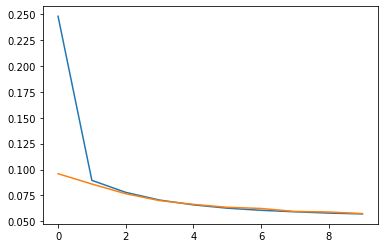

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

if use_class_weights:
    print("Using class weights")
    criterion = nn.BCEWithLogitsLoss(weight = class_weights)
else:
    print("Not using class weights")
    criterion = nn.BCEWithLogitsLoss()
train_losses = []
val_losses = []
waited = 0

min_val_loss = np.inf

for epoch in range(epochs):
    epoch_train_loss = []
    
    for embeddings_batch, labels_batch in batchify_tokens_tags(train_input, train_output, batch_size):
        optim.zero_grad()
        out = model.forward(embeddings_batch)
        
        # logits_final, labels_final = outputs_keep_useful_part(out.logits, labels_batch, useful_pos_batch)
        loss = criterion(out, labels_batch)
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_loss)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = compute_loss(model, val_input, val_output, batch_size, criterion)
    
    print(f"Epoch {epoch + 1}: Train loss = {epoch_train_loss}, Val loss = {epoch_val_loss}")
    
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'saved_models/MOVE_AGENT_REQ_LSTM.pt')
    
    if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
        waited += 1
        if waited > patience:
                val_losses.append(epoch_val_loss)
                break
    else:
        waited = 0
    
    val_losses.append(epoch_val_loss)

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()


In [ ]:
model.load_state_dict(torch.load('saved_models/MOVE_AGENT_REQ_LSTM.pt'))

predicted_output = predict(model, test_input, batch_size)

acc = accuracy_score(test_output, predicted_output)
report = classification_report(test_output, predicted_output, target_names = mlb.classes_, digits = 3)
print(report)
print(f'acc = {acc}')

                       precision    recall  f1-score   support

              NOTHING      0.922     0.905     0.914      2082
      booking-bookday      0.000     0.000     0.000        10
   booking-bookpeople      0.000     0.000     0.000        10
     booking-bookstay      0.000     0.000     0.000         5
     booking-booktime      0.000     0.000     0.000         7
           hotel-area      0.659     0.503     0.571       177
        hotel-bookday      0.591     0.126     0.208       103
     hotel-bookpeople      0.000     0.000     0.000        60
       hotel-bookstay      0.000     0.000     0.000       100
       hotel-booktime      0.000     0.000     0.000         0
       hotel-internet      0.000     0.000     0.000        18
           hotel-name      0.000     0.000     0.000         8
        hotel-parking      0.000     0.000     0.000        22
     hotel-pricerange      0.375     0.051     0.090       118
          hotel-stars      0.000     0.000     0.000  

/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
